In [ ]:
#import libraries
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import sys

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline

#setting maximum row of 1000 rows as result display
pd.set_option('display.max_row', 1000)

In [ ]:
#initiating google colab libraries:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#execute below code when to write file to google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Data

In [ ]:
#read input data file from google drive
link = 'https://drive.google.com/open?id=129JPWF6XDifE8NiMlZZDrpP9d7hp3_KR'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('UCF_TLDClustering.txt')
data = pd.read_csv('UCF_TLDClustering.txt', sep="\|\|", engine='python')

129JPWF6XDifE8NiMlZZDrpP9d7hp3_KR


In [ ]:
#read input data file from local drive
data = pd.read_csv('UCF_TLDClustering.txt', sep="\|\|", engine='python')

In [ ]:
#input data columns
data.columns = ["StoreID", "StoreGroup", "PeriodID", "TicketID", "ItemName", "ItemCategory", "Qty", "Sales", "Modifier"]

In [ ]:
#check initial records of the data
data.head()

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1{,}A{,}20180801{,}1{,}Chevy Ajax{,}Automobile{,}1{,}499{,}0
1,1{,}A{,}20180801{,}2{,}Chevy Spark{,}Automobile{,}1{,}499{,}0
2,1{,}A{,}20180801{,}3{,}Chevy Colorado{,}Automobile{,}1{,}799{,}0
3,1{,}A{,}20180801{,}3{,}Chevy Gemini{,}Automobile{,}1{,}679{,}0
4,1{,}A{,}20180801{,}3{,}WND{,}Phones{,}2{,}0{,}1


In [ ]:
#data description
data.describe()

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
count,12811321,12811321,12811321,12811321,12811321,12811321,12811321,12811321,12811321
unique,90,7,365,498,397,7,91,1203,2
top,202{,}F{,}20190302{,}32{,}Apple{,}Automobile{,}1{,}0{,}0
freq,298687,2053989,54210,100581,1313144,5724853,10850445,1851939,10959386


In [ ]:
df = pd.DataFrame(data)

# Data Preparation
  * Cleaning data - removal of '{' and '}'

In [ ]:
df = df.applymap(lambda x: x.replace('{', ''))

In [ ]:
df = df.applymap(lambda x: x.replace('}', ''))

In [ ]:
#check data
df.head(10)

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1,A,20180801,1,Chevy Ajax,Automobile,1,499,0
1,1,A,20180801,2,Chevy Spark,Automobile,1,499,0
2,1,A,20180801,3,Chevy Colorado,Automobile,1,799,0
3,1,A,20180801,3,Chevy Gemini,Automobile,1,679,0
4,1,A,20180801,3,WND,Phones,2,0,1
5,1,A,20180801,4,Luxury Package,Accessories,1,199,0
6,1,A,20180801,4,Apple,Phones,2,378,0
7,1,A,20180801,4,Ford Expedition,Automobile,1,829,0
8,1,A,20180801,4,Bose Speakers,Accessories,1,299,0
9,1,A,20180801,5,Chevy Spark,Automobile,1,499,0


In [ ]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811321 entries, 0 to 12811320
Data columns (total 9 columns):
StoreID         object
StoreGroup      object
PeriodID        object
TicketID        object
ItemName        object
ItemCategory    object
Qty             object
Sales           object
Modifier        object
dtypes: object(9)
memory usage: 879.7+ MB


In [ ]:
#check for NaNs, null values
df.loc[df.isna().any(axis=1),:]

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier


In [ ]:
#data description with include all
df.describe(include='all')

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
count,12811321,12811321,12811321,12811321,12811321,12811321,12811321,12811321,12811321
unique,90,7,365,498,397,7,91,1203,2
top,202,F,20190302,32,Apple,Automobile,1,0,0
freq,298687,2053989,54210,100581,1313144,5724853,10850445,1851939,10959386


In [ ]:
#check for unique store groups
df.StoreGroup.unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

In [ ]:
df1 = df[df.StoreID =='1']

In [ ]:
#check initial data with store id = 1 dataframe
df1.head(10)

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1,A,20180801,1,Chevy Ajax,Automobile,1,499,0
1,1,A,20180801,2,Chevy Spark,Automobile,1,499,0
2,1,A,20180801,3,Chevy Colorado,Automobile,1,799,0
3,1,A,20180801,3,Chevy Gemini,Automobile,1,679,0
4,1,A,20180801,3,WND,Phones,2,0,1
5,1,A,20180801,4,Luxury Package,Accessories,1,199,0
6,1,A,20180801,4,Apple,Phones,2,378,0
7,1,A,20180801,4,Ford Expedition,Automobile,1,829,0
8,1,A,20180801,4,Bose Speakers,Accessories,1,299,0
9,1,A,20180801,5,Chevy Spark,Automobile,1,499,0


In [ ]:
#dataframe description
df1.describe(include='all')

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
count,98675,98675,98675,98675,98675,98675,98675,98675,98675
unique,1,1,339,249,274,7,11,317,2
top,1,A,20190330,36,Apple,Automobile,1,199,0
freq,98675,98675,898,1080,13731,46563,83046,13458,87394


In [ ]:
#check unique item name for store id 1 data
df1.ItemName.unique()

In [ ]:
#store id 1 dataframe information
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98675 entries, 0 to 98674
Data columns (total 9 columns):
StoreID         98675 non-null object
StoreGroup      98675 non-null object
PeriodID        98675 non-null object
TicketID        98675 non-null object
ItemName        98675 non-null object
ItemCategory    98675 non-null object
Qty             98675 non-null object
Sales           98675 non-null object
Modifier        98675 non-null object
dtypes: object(9)
memory usage: 7.5+ MB


In [ ]:
#check the type of data
type(df1)

pandas.core.frame.DataFrame

In [ ]:
#check all store group values for store id 1
df1.StoreGroup.unique()

array(['A'], dtype=object)

In [ ]:
#check unique Item Category for Store ID 1 data
df1.ItemCategory.unique()

array(['Automobile', 'Phones', 'Accessories', 'Dogs', 'Homes', 'Bicycle',
       'Color'], dtype=object)

  * Cleaning the ItemNames column values

In [ ]:
df1['ItemName'] = df1['ItemName'].str.replace(' ','-')
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1,A,20180801,1,Chevy-Ajax,Automobile,1,499,0
1,1,A,20180801,2,Chevy-Spark,Automobile,1,499,0
2,1,A,20180801,3,Chevy-Colorado,Automobile,1,799,0
3,1,A,20180801,3,Chevy-Gemini,Automobile,1,679,0
4,1,A,20180801,3,WND,Phones,2,0,1


#Data Exploration

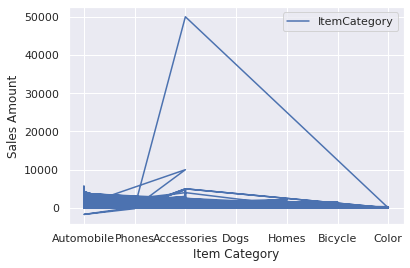

In [ ]:
#plot Sales Amount with respect to Item Category
plt.plot(df1.ItemCategory, df1['Sales'].astype(str).astype(int))
plt.legend(['ItemCategory'])
plt.xlabel('Item Category')
plt.ylabel('Sales Amount')
plt.show()

In [ ]:
#check minimum sales amount
min(df1.Sales)

'-1698'

In [ ]:
#check records with sales less than 0  - dfS1TimeFrame1 dfS1TimeFrame2
negativeVal = df1[df1.Sales < '0']
negativeVal

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
2251,1,A,20180809,33,Ford-Focus,Automobile,2,-1698,0
2252,1,A,20180809,33,Google,Phones,1,-199,0


In [ ]:
#check records with sales less than 0
tckt33Det = df1[(df1.TicketID == '33') & (df1.PeriodID == '20180809')]
tckt33Det

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
2251,1,A,20180809,33,Ford-Focus,Automobile,2,-1698,0
2252,1,A,20180809,33,Google,Phones,1,-199,0
2253,1,A,20180809,33,WND,Phones,1,0,1


In [ ]:
df1['Sales'] = df1['Sales'].str.replace('-','')
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1,A,20180801,1,Chevy-Ajax,Automobile,1,499,0
1,1,A,20180801,2,Chevy-Spark,Automobile,1,499,0
2,1,A,20180801,3,Chevy-Colorado,Automobile,1,799,0
3,1,A,20180801,3,Chevy-Gemini,Automobile,1,679,0
4,1,A,20180801,3,WND,Phones,2,0,1


In [ ]:
negativeVal = df1[df1.Sales < '0']
negativeVal

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier


  * Changing the numerical valued columns to type int

In [ ]:
df1['StoreID'] = df1['StoreID'].astype(str).astype(int)
df1['PeriodID'] = df1['PeriodID'].astype(str).astype(int)
df1['TicketID'] = df1['TicketID'].astype(str).astype(int)
df1['Qty'] = df1['Qty'].astype(str).astype(int)
df1['Sales'] = df1['Sales'].astype(str).astype(int)
df1['Modifier'] = df1['Modifier'].astype(str).astype(int)
#df1['StoreGroup'] = df1['StoreGroup'].astype('str')
#df1['ItemName'] = df1['ItemName'].astype('str')
#df1['ItemCategory'] = df1['ItemCategory'].astype('str')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98675 entries, 0 to 98674
Data columns (total 9 columns):
StoreID         98675 non-null int64
StoreGroup      98675 non-null object
PeriodID        98675 non-null int64
TicketID        98675 non-null int64
ItemName        98675 non-null object
ItemCategory    98675 non-null object
Qty             98675 non-null int64
Sales           98675 non-null int64
Modifier        98675 non-null int64
dtypes: int64(6), object(3)
memory usage: 7.5+ MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

# Create Base Period for analysis

  * Creating base period with Store 1 with time frame Aug 2018 - Jul 2019

In [ ]:
store1DF = df1
store1DF.head()

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
0,1,A,20180801,1,Chevy-Ajax,Automobile,1,499,0
1,1,A,20180801,2,Chevy-Spark,Automobile,1,499,0
2,1,A,20180801,3,Chevy-Colorado,Automobile,1,799,0
3,1,A,20180801,3,Chevy-Gemini,Automobile,1,679,0
4,1,A,20180801,3,WND,Phones,2,0,1


In [ ]:
store1DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98675 entries, 0 to 98674
Data columns (total 9 columns):
StoreID         98675 non-null int64
StoreGroup      98675 non-null object
PeriodID        98675 non-null int64
TicketID        98675 non-null int64
ItemName        98675 non-null object
ItemCategory    98675 non-null object
Qty             98675 non-null int64
Sales           98675 non-null int64
Modifier        98675 non-null int64
dtypes: int64(6), object(3)
memory usage: 10.0+ MB


  * Creating dataframe 'dfS1TimeFrame1' for Store 1 with  timeframe August 1st -  December 31 2018

In [ ]:
dfS1TimeFrame1 = df1[df1.PeriodID <= 20181231]

  * Creating dataframe 'dfS1TimeFrame2' for Store 1 with timeframe  January 1st to July 31st 2019

In [ ]:
dfS1TimeFrame2 = df1[df1.PeriodID >= 20190101]

In [ ]:
#dataframe information
dfS1TimeFrame1.info()
dfS1TimeFrame2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42859 entries, 0 to 42858
Data columns (total 9 columns):
StoreID         42859 non-null int64
StoreGroup      42859 non-null object
PeriodID        42859 non-null int64
TicketID        42859 non-null int64
ItemName        42859 non-null object
ItemCategory    42859 non-null object
Qty             42859 non-null int64
Sales           42859 non-null int64
Modifier        42859 non-null int64
dtypes: int64(6), object(3)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55816 entries, 42859 to 98674
Data columns (total 9 columns):
StoreID         55816 non-null int64
StoreGroup      55816 non-null object
PeriodID        55816 non-null int64
TicketID        55816 non-null int64
ItemName        55816 non-null object
ItemCategory    55816 non-null object
Qty             55816 non-null int64
Sales           55816 non-null int64
Modifier        55816 non-null int64
dtypes: int64(6), object(3)
memory usage: 4.3+ MB


  * Scatterplot of TicketID vs Quantity

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


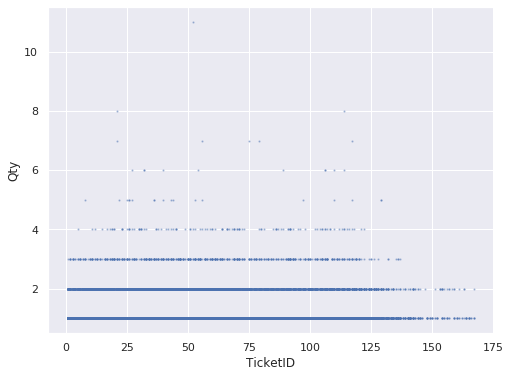

In [ ]:
#TimeFrame 1
def var_scatter(dfS1TimeFrame1, var):
    ax=None
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    dfS1TimeFrame1.plot.scatter(x=var , y="Qty", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(dfS1TimeFrame1, "TicketID");

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


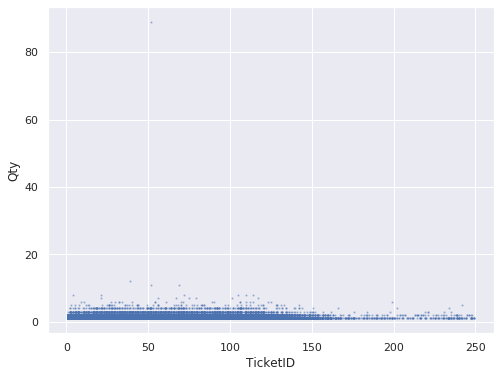

In [ ]:
#store1DF
def var_scatter(store1DF, var):
    ax=None
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    store1DF.plot.scatter(x=var , y="Qty", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(store1DF, "TicketID");

  * Comparision plot of Quantity and Sales with respect to each Ticket ID

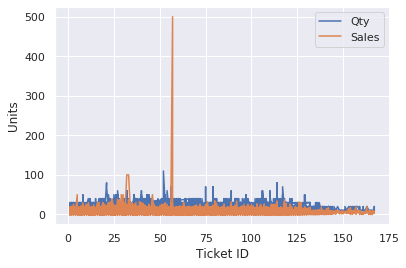

In [ ]:
plt.plot(dfS1TimeFrame1.TicketID,dfS1TimeFrame1.Qty * 10)
plt.plot(dfS1TimeFrame1.TicketID,dfS1TimeFrame1.Sales/10**2)
plt.legend(['Qty', 'Sales'])
plt.xlabel('Ticket ID')
plt.ylabel('Units')
plt.show()

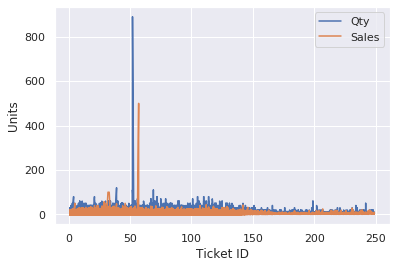

In [ ]:
plt.plot(store1DF.TicketID, store1DF.Qty * 10)
plt.plot(store1DF.TicketID, store1DF.Sales/10**2)
plt.legend(['Qty', 'Sales'])
plt.xlabel('Ticket ID')
plt.ylabel('Units')
plt.show()

  * Comparision of Quantity and Sales with respect to each TicketID as percentage growth when compared with sales amount of first TicketID

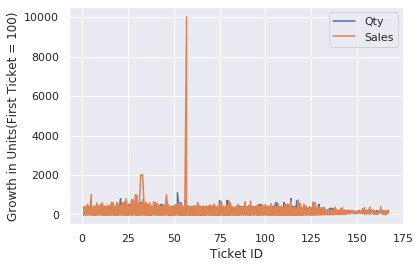

In [ ]:
plt.plot(dfS1TimeFrame1.TicketID,dfS1TimeFrame1.Qty / dfS1TimeFrame1.Qty.iloc[0] * 100)
plt.plot(dfS1TimeFrame1.TicketID,dfS1TimeFrame1.Sales / dfS1TimeFrame1.Sales.iloc[0]*100)
plt.legend(['Qty', 'Sales'])
plt.xlabel('Ticket ID')
plt.ylabel('Growth in Units(First Ticket = 100)')
plt.show()

  * Determining the outlier Sales amount

In [ ]:
maxSalesValue = store1DF[store1DF.Sales > 5000]
maxSalesValue

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
32908,1,A,20181128,57,Keychain,Accessories,1,50000,0
39175,1,A,20181221,32,Keychain,Accessories,1,10000,0
39176,1,A,20181221,33,Keychain,Accessories,1,10000,0
81722,1,A,20190605,29,Chevy-Chevelle,Automobile,3,5697,0


  * Pattern of higher sales value for respective ItemName 'Keychain'

  * Determining higher quantity orders for respective ticketids

  * Plot Quatity with respect to Sales

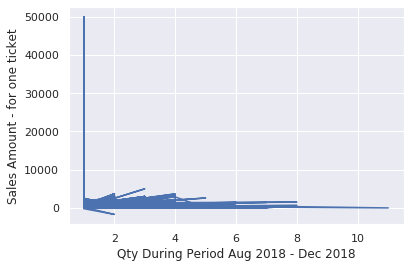

In [ ]:
plt.plot(dfS1TimeFrame1.Qty, dfS1TimeFrame1.Sales)
plt.xlabel('Qty During Period Aug 2018 - Dec 2018')
plt.ylabel('Sales Amount - for one ticket')
plt.show()

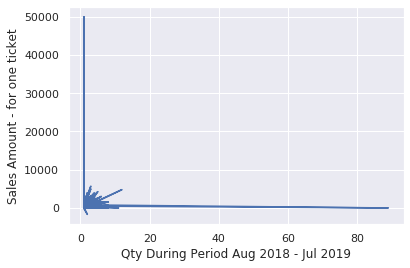

In [ ]:
plt.plot(store1DF.Qty, store1DF.Sales)
plt.xlabel('Qty During Period Aug 2018 - Jul 2019')
plt.ylabel('Sales Amount - for one ticket')
plt.show()

  * Order details with 0 sales amount

In [ ]:
zeroSales = store1DF[store1DF.Sales == 0]
zeroSales.describe(include='all')

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
count,11281.0,11281,1.128100e+04,11281.000000,11281,11281,11281.000000,11281.0,11281.0
unique,NaN,1,NaN,NaN,11,5,NaN,NaN,NaN
top,NaN,A,NaN,NaN,WND,Phones,NaN,NaN,NaN
freq,NaN,11281,NaN,NaN,9151,9833,NaN,NaN,NaN
mean,1.0,NaN,2.018655e+07,55.440652,NaN,NaN,1.390214,0.0,1.0
std,0.0,NaN,4.646784e+03,35.602385,NaN,NaN,1.082758,0.0,0.0
min,1.0,NaN,2.018080e+07,1.000000,NaN,NaN,1.000000,0.0,1.0
25%,1.0,NaN,2.018110e+07,27.000000,NaN,NaN,1.000000,0.0,1.0
50%,1.0,NaN,2.019020e+07,51.000000,NaN,NaN,1.000000,0.0,1.0
75%,1.0,NaN,2.019051e+07,79.000000,NaN,NaN,2.000000,0.0,1.0


In [ ]:
#authentical google drive to save file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#google drive mount for location to save files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Create Corpus Documents
  * Create Corpus for ItemName
  * Corpus Document columns - StoreID|PeriodID|TicketID|ItemName|Sales

In [ ]:
def CreateCorpusFromDataFrame(inputData):
    itemNameDict = {}
    id = 1
    try:
        global corpusfile
        #corpusfile = open('/content/gdrive/My Drive/CAPSTONE Project: Data Pirates/itemNameDocumentStr1TF1.txt', 'w')
        corpusfile = open('itemNameDocumentStr1.txt', 'w')
        corpusfile.write('StoreID|PeriodID|TicketID|ItemName|Sales\n')

        for index, r in inputData.iterrows():
            storeID = r['StoreID']
            periodID = r['PeriodID']
            ticketID = r['TicketID']
            itemName = r['ItemName']
            qty = r['Qty']
            totalSales = int(r['Sales'])
            testName = ""
            keyVal = str(periodID)+str(ticketID)
            #print(keyVal)

            if keyVal in itemNameDict:
                value = itemNameDict[keyVal]
                c_itemname = value.split('|')[3]
                if qty > 1:
                    for x in range(qty):
                        if testName == "":
                            testName = itemName
                        else:
                            testName =  testName +' '+itemName
                    #print("ItemName:::::::" + testName)
                else:
                    testName = itemName

                n_itemname = c_itemname + ' ' + testName
                #print(":::::::" + n_itemname)
                c_salesValue = int(value.split('|')[4])
                n_salesValue = c_salesValue + totalSales
                corpusString = str(storeID) + "|" + str(periodID) + "|" + str(ticketID) + "|" + str(n_itemname) + "|" + str(n_salesValue)
                itemNameDict.update({keyVal: corpusString})
            else:
                if qty > 1:
                    for x in range(qty-1):
                        itemName = itemName + ' ' + itemName
                #print("ItemName:::::::" + itemName)
                corpusString = str(storeID) + "|" + str(periodID) + "|" + str(ticketID) + "|" + str(itemName) + "|" + str(totalSales)
                itemNameDict.update({keyVal: corpusString})

            id = id + 1

        for x in itemNameDict:
            corpusfile.write(itemNameDict[x] + '\n')

    finally:
        corpusfile.close()


#CreateCorpusFromDataFrame(dfS1TimeFrame1)
CreateCorpusFromDataFrame(store1DF)

# Load Corpus document
  * itemNameDocumentStr1TF1  - Base period - Store 1 TF1 (Aug 2018 - Dec 2019)
  * itemNameDocumentStr1     - Base period - Store 1 (Aug 2018 - Jul 2019)

In [ ]:
#initiating google colab libraries:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

  * Load corpus document for ItemName from google drive

In [ ]:
#TimeFrame 1
linkName = 'https://drive.google.com/open?id=1OnylOkywrDl5oeJt6AhwpMZZLJXXuixx'
fluff, id = linkName.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('itemNameDocumentStr1TF1.txt')
itemNameDataStr1TF1 = pd.read_csv('itemNameDocumentStr1TF1.txt', sep="|", engine='python')
itemNameDataStr1TF1.info()

1OnylOkywrDl5oeJt6AhwpMZZLJXXuixx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518 entries, 0 to 13517
Data columns (total 5 columns):
StoreID     13518 non-null int64
PeriodID    13518 non-null int64
TicketID    13518 non-null int64
ItemName    13518 non-null object
Sales       13518 non-null int64
dtypes: int64(4), object(1)
memory usage: 528.2+ KB


In [ ]:
#Base Period
linkName = 'https://drive.google.com/open?id=1-4gG53zJ6m77j-H4ozn0SgJkBXv62xdR'
fluff, id = linkName.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('itemNameDocumentStr1.txt')
itemNameDataStr1 = pd.read_csv('itemNameDocumentStr1.txt', sep="|", engine='python')
itemNameDataStr1.info()

1-4gG53zJ6m77j-H4ozn0SgJkBXv62xdR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31244 entries, 0 to 31243
Data columns (total 5 columns):
StoreID     31244 non-null int64
PeriodID    31244 non-null int64
TicketID    31244 non-null int64
ItemName    31244 non-null object
Sales       31244 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


##Load corpus document for ItemName
  * Load corpus document for ItemName from local drive

In [ ]:
itemNameDataStr1TF1 = pd.read_csv('itemNameDocumentStr1TF1.txt', sep="|", engine='python')
itemNameDataStr1TF1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518 entries, 0 to 13517
Data columns (total 5 columns):
StoreID     13518 non-null int64
PeriodID    13518 non-null int64
TicketID    13518 non-null int64
ItemName    13518 non-null object
Sales       13518 non-null int64
dtypes: int64(4), object(1)
memory usage: 528.2+ KB


In [ ]:
#check corpus document data
itemNameDataStr1TF1.head()

,StoreID,PeriodID,TicketID,ItemName,Sales
0,1,20180801,1,Chevy-Ajax,499
1,1,20180801,2,Chevy-Spark,499
2,1,20180801,3,Chevy-Colorado Chevy-Gemini WND WND,1478
3,1,20180801,4,Luxury-Package Apple Apple Ford-Expedition Bos...,1705
4,1,20180801,5,Chevy-Spark,499


In [ ]:
itemNameDataStr1 = pd.read_csv('itemNameDocumentStr1.txt', sep="|", engine='python')
itemNameDataStr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31244 entries, 0 to 31243
Data columns (total 5 columns):
StoreID     31244 non-null int64
PeriodID    31244 non-null int64
TicketID    31244 non-null int64
ItemName    31244 non-null object
Sales       31244 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


#TFIDF
  * using sklearn feature extraction 'TfidfVectorizer' for ItemName Base Period - itemNameDataStr1TF1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

In [ ]:
#select column to convert to list here
itemNameCorpusStr1TF1 = itemNameDataStr1TF1["ItemName"].tolist()
#itemNameCorpusStr1TF1
itemNameCorpusStr1TF1 = [x.lower() for x in itemNameCorpusStr1TF1]
len(itemNameCorpusStr1TF1)

13518

In [ ]:
#set() takes the unique values and set in vocabulary
vocabulary = set()
for documentValue in itemNameCorpusStr1TF1:
    vocabulary.update(documentValue.split())

len(vocabulary)

250

In [ ]:
#print(vocabulary)

In [ ]:
vocabulary = list(vocabulary)

NameError: ignored

In [ ]:
#vocabulary

In [ ]:
#assigning index value to each vocabulary word
wordInd = {word: idx for idx, word in enumerate(vocabulary)}

In [ ]:
#wordInd

In [ ]:
tfidf = TfidfVectorizer(vocabulary=vocabulary, token_pattern=r"(?u)\S\S+")

In [ ]:
tfidf.fit(itemNameCorpusStr1TF1)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\S\\S+', tokenizer=None,
                use_idf=T...
                            'obd2-scanner', 'built-in-phone', 'chevy-blazer',
                            'chevy-traverse', 'kia-k4', 'bmc', 'ford-laser',
                            'chevy-uplander', 'kia-sedona', 'periwinkle',
                            'chevy-monte-carlo', 'chrysler-town-and-country',
                            'kia-stinger', 'ford-flex', 'ford-explorer',
                            'toyota-crown', 'jamis', 'metallic-blue',
                            'car-sales-decal', 'chrysler-fifth-avenue',
       

In [ ]:
tfidf.transform(itemNameCorpusStr1TF1)

<13518x250 sparse matrix of type '<class 'numpy.float64'>'
	with 42859 stored elements in Compressed Sparse Row format>

In [ ]:
#initializing tfidfItemName dataframe with all column values with 0 value
tfidfItemNameStr1TF1DF = pd.DataFrame()
map = {'400w-power-inverter': 0,
 '600w-power-inverter': 0,
 'alan': 0,
 'allview': 0,
 'amazon': 0,
 'amoi': 0,
 'apartment': 0,
 'apple': 0,
 'archos': 0,
 'asus': 0,
 'at&t': 0,
 'australian-shepherd': 0,
 'backup-camera': 0,
 'benq-siemens': 0,
 'bike-hauler': 0,
 'blackberry': 0,
 'blackview': 0,
 'bmc': 0,
 'bobble-head': 0,
 'bose-speakers': 0,
 'boxer': 0,
 'built-in-phone': 0,
 'bungalow': 0,
 'cabin': 0,
 'cannondale': 0,
 'car-sales-decal': 0,
 'carriage/coach': 0,
 'chalet': 0,
 'chevy-210': 0,
 'chevy-ajax': 0,
 'chevy-astro': 0,
 'chevy-beretta': 0,
 'chevy-blazer': 0,
 'chevy-c/k': 0,
 'chevy-camaro': 0,
 'chevy-cameo': 0,
 'chevy-caprice': 0,
 'chevy-cavalier': 0,
 'chevy-celta': 0,
 'chevy-chevelle': 0,
 'chevy-cobalt': 0,
 'chevy-colorado': 0,
 'chevy-constantia': 0,
 'chevy-corvair': 0,
 'chevy-delray': 0,
 'chevy-forester': 0,
 'chevy-g506': 0,
 'chevy-gemini': 0,
 'chevy-greenbrier': 0,
 'chevy-hhr': 0,
 'chevy-impala': 0,
 'chevy-lakewood': 0,
 'chevy-lanos': 0,
 'chevy-lee': 0,
 'chevy-mercury': 0,
 'chevy-monte-carlo': 0,
 'chevy-nova': 0,
 'chevy-onix': 0,
 'chevy-sonic': 0,
 'chevy-spark': 0,
 'chevy-standard': 0,
 'chevy-tahoe': 0,
 'chevy-trailblazer': 0,
 'chevy-traverse': 0,
 'chevy-uplander': 0,
 'chevy-van': 0,
 'chevy-vega': 0,
 'chevy-viking': 0,
 'chevy-viva': 0,
 'chrysler-300': 0,
 'chrysler-airstream': 0,
 'chrysler-aspen': 0,
 'chrysler-cordoba': 0,
 'chrysler-crossfire': 0,
 'chrysler-fifth-avenue': 0,
 'chrysler-newport': 0,
 'chrysler-prowler': 0,
 'chrysler-royal': 0,
 'chrysler-saratoga': 0,
 'chrysler-sebring': 0,
 'chrysler-sunbeem': 0,
 'chrysler-town-and-country': 0,
 'co-op': 0,
 'condominium': 0,
 'cooler': 0,
 'cottage': 0,
 'crimson': 0,
 'dash-camera': 0,
 'desert-sand': 0,
 'dodge-330': 0,
 'dodge-400': 0,
 'dodge-aries': 0,
 'dodge-durango': 0,
 'dodge-intrepid': 0,
 'dodge-kingsway': 0,
 'dodge-lancer': 0,
 'dodge-meadowbrook': 0,
 'dodge-olara': 0,
 'dodge-omni': 0,
 'dodge-ram-2500': 0,
 'dodge-ram-3500': 0,
 'dodge-stratus': 0,
 'dodge-viper': 0,
 'emergency-roadside-kit': 0,
 'febreeze-spray': 0,
 'felt': 0,
 'fire-extinguisher': 0,
 'first-aid-kit': 0,
 'fish-for-trailer-hitch': 0,
 'fix-a-flat': 0,
 'ford-abeille': 0,
 'ford-aspire': 0,
 'ford-b-max': 0,
 'ford-bronco': 0,
 'ford-camete': 0,
 'ford-contour': 0,
 'ford-crestline': 0,
 'ford-crown-victoria': 0,
 'ford-custom-500': 0,
 'ford-custom-deluxe': 0,
 'ford-del-rey': 0,
 'ford-e150': 0,
 'ford-e250': 0,
 'ford-edge': 0,
 'ford-eifel': 0,
 'ford-endeavor': 0,
 'ford-escape': 0,
 'ford-escort': 0,
 'ford-expedition': 0,
 'ford-explorer': 0,
 'ford-explorer-sport-trac': 0,
 'ford-f-550': 0,
 'ford-f150': 0,
 'ford-f250': 0,
 'ford-festiva': 0,
 'ford-five-hundred': 0,
 'ford-flex': 0,
 'ford-focus': 0,
 'ford-fusion': 0,
 'ford-gt40': 0,
 'ford-gtx1': 0,
 'ford-kuga': 0,
 'ford-laser': 0,
 'ford-lobo': 0,
 'ford-model-4-46': 0,
 'ford-model-69a/gga': 0,
 'ford-model-73/77': 0,
 'ford-model-ac': 0,
 'ford-model-b': 0,
 'ford-model-c': 0,
 'ford-probe': 0,
 'ford-quadricycle': 0,
 'ford-ranch-wagon': 0,
 'ford-super-deluxe': 0,
 'ford-svt-raptor': 0,
 'ford-taurus': 0,
 'ford-telstar': 0,
 'ford-thunderbird': 0,
 'ford-transcontinental': 0,
 'ford-xl': 0,
 'french-bulldog': 0,
 'fuji': 0,
 'german-pointer': 0,
 'german-shepherd': 0,
 'golden-retriever': 0,
 'google': 0,
 'gps-unit': 0,
 'greater-swiss-mountain-dog': 0,
 'halogen-lights': 0,
 'highspeed-charger': 0,
 'in-law-suite': 0,
 'inflatable-car-jack': 0,
 'jamis': 0,
 'jumper-cables': 0,
 'keychain': 0,
 'kia-k4': 0,
 'kia-optima': 0,
 'kia-picanto': 0,
 'kia-rio': 0,
 'kia-sedona': 0,
 'kia-stinger': 0,
 'kia-telluride': 0,
 'leather-cleaner': 0,
 'lg': 0,
 'light-covers': 0,
 'lincoln-2010': 0,
 'lincoln-continental': 0,
 'lincoln-mkx': 0,
 'luggage-hauler': 0,
 'luxury-package': 0,
 'map-holder': 0,
 'marin': 0,
 'merida': 0,
 'metallic-blue': 0,
 'microsoft': 0,
 'multi-family': 0,
 'navigation-system': 0,
 'nec': 0,
 'newfoundland': 0,
 'nylon-seat-covers': 0,
 'obd2-scanner': 0,
 'ochre': 0,
 'parking-sensors': 0,
 'periwinkle': 0,
 'pillows': 0,
 'pomeranian': 0,
 'poodle': 0,
 'preimum-car-wash': 0,
 'premium-seat-covers': 0,
 'radar-detector': 0,
 'ranch-style': 0,
 'rear-spoiler': 0,
 'regular-floor-mats': 0,
 'roll-bar': 0,
 'roll-cage': 0,
 'safety-hammer': 0,
 'samsung': 0,
 'saturn-ion': 0,
 'saturn-sky': 0,
 'seatbelt-cutter': 0,
 'shetland-sheepdog': 0,
 'single-family-(detached)': 0,
 'smart-dirving-assistant': 0,
 'solor-powered-vent': 0,
 'sony': 0,
 'spare-tire-cover': 0,
 'sport-package': 0,
 'suction-grip': 0,
 'tan': 0,
 'tinted-windows': 0,
 'tiny': 0,
 'towing-package': 0,
 'townhome': 0,
 'toyota-4runner': 0,
 'toyota-century': 0,
 'toyota-corolla': 0,
 'toyota-crown': 0,
 'toyota-fortuner': 0,
 'toyota-land-cruiser': 0,
 'toyota-porte': 0,
 'toyota-prius': 0,
 'toyota-tacoma': 0,
 'toyota-tundra': 0,
 'toyota-voxy': 0,
 'trek': 0,
 'ultramarine': 0,
 'vehicle-cover': 0,
 'wheelchair-ramp': 0,
 'wnd': 0,
 'worksman-cycles': 0}

NameError: ignored

In [ ]:
#calculating TFIDF values for each document of the corpus and populating in the dataframe
scoreValue={}
for document in itemNameCorpusStr1TF1:
    score={}
    transform = tfidf.transform([document])
    for value in document.split():
        score[value] = transform[0, tfidf.vocabulary_[value]]
    scoreValue = sorted(score.items(), key=operator.itemgetter(1), reverse=True)
    new_row = pd.Series()
    for a in scoreValue:
      map[a[0]] =a[1]
    new_row = pd.Series(map)
    tfidfItemNameStr1TF1DF = tfidfItemNameStr1TF1DF.append(new_row, ignore_index=True)

In [ ]:
#check tfidf item name data
tfidfItemNameStr1TF1DF.head()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,backup-camera,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,chalet,chevy-210,chevy-ajax,chevy-astro,chevy-beretta,chevy-blazer,chevy-c/k,chevy-camaro,chevy-cameo,chevy-caprice,chevy-cavalier,chevy-celta,chevy-chevelle,...,ranch-style,rear-spoiler,regular-floor-mats,roll-bar,roll-cage,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-land-cruiser,toyota-porte,toyota-prius,toyota-tacoma,toyota-tundra,toyota-voxy,trek,ultramarine,vehicle-cover,wheelchair-ramp,wnd,worksman-cycles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0


In [ ]:
#check dataframe shape
tfidfItemNameStr1TF1DF.shape

(13518, 250)

In [ ]:
#check tfidf dataframe description
tfidfItemNameStr1TF1DF.describe()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,backup-camera,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,chalet,chevy-210,chevy-ajax,chevy-astro,chevy-beretta,chevy-blazer,chevy-c/k,chevy-camaro,chevy-cameo,chevy-caprice,chevy-cavalier,chevy-celta,chevy-chevelle,...,ranch-style,rear-spoiler,regular-floor-mats,roll-bar,roll-cage,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-land-cruiser,toyota-porte,toyota-prius,toyota-tacoma,toyota-tundra,toyota-voxy,trek,ultramarine,vehicle-cover,wheelchair-ramp,wnd,worksman-cycles
count,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,...,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000
mean,0.462699,0.556516,0.536020,0.534976,0.587988,0.633888,0.539433,0.330249,0.578658,0.676488,0.523083,0.694253,0.472596,0.515523,0.547385,0.546193,0.743471,0.489944,0.458101,0.451109,0.775984,0.650545,0.592998,0.528315,0.470514,0.526267,0.547760,0.504606,0.653800,0.941046,0.523047,0.619537,0.668587,0.564816,0.673767,0.278068,0.722115,0.643878,0.077556,0.641169,...,0.521401,0.539961,0.537553,0.571950,0.688331,0.626286,0.391075,0.585910,0.663791,0.227489,0.916102,0.503869,0.430336,0.639327,0.529570,0.531599,0.490800,0.430688,0.400503,0.600223,0.636746,0.603017,0.582970,0.624067,0.577830,0.584659,0.615616,0.701579,0.555815,0.582846,0.945868,0.630456,0.623645,0.567860,0.025037,0.650321,0.542070,0.530075,0.391852,0.529341
std,0.263316,0.183038,0.148424,0.175342,0.152716,0.259514,0.154036,0.150114,0.158553,0.345101,0.177321,0.418222,0.096283,0.138224,0.216165,0.180194,0.268102,0.143339,0.355516,0.147631,0.153011,0.265202,0.194978,0.292861,0.148317,0.155685,0.197898,0.240040,0.161750,0.120777,0.497384,0.206770,0.195103,0.364648,0.171261,0.335120,0.169093,0.185598,0.228130,0.196768,...,0.178397,0.154518,0.334296,0.175059,0.204629,0.173868,0.145845,0.166675,0.404511,0.301221,0.198208,0.163786,0.100292,0.149292,0.155146,0.146913,0.143163,0.295071,0.282295,0.179980,0.184896,0.181865,0.172642,0.217540,0.195503,0.191136,0.209260,0.317764,0.374211,0.389642,0.159526,0.184302,0.207641,0.198313,0.107549,0.177392,0.141863,0.207974,0.160285,0.164247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.565763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
#take out rows with all values as 0
tfidfItemNameStr1TF1DF = tfidfItemNameStr1TF1DF.loc[:,(tfidfItemNameStr1TF1DF != 0).any(axis=0)]

In [ ]:
tfidfItemNameStr1TF1DF.describe()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,backup-camera,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,chalet,chevy-210,chevy-ajax,chevy-astro,chevy-beretta,chevy-blazer,chevy-c/k,chevy-camaro,chevy-cameo,chevy-caprice,chevy-cavalier,chevy-celta,chevy-chevelle,...,ranch-style,rear-spoiler,regular-floor-mats,roll-bar,roll-cage,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-land-cruiser,toyota-porte,toyota-prius,toyota-tacoma,toyota-tundra,toyota-voxy,trek,ultramarine,vehicle-cover,wheelchair-ramp,wnd,worksman-cycles
count,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,...,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000
mean,0.462699,0.556516,0.536020,0.534976,0.587988,0.633888,0.539433,0.330249,0.578658,0.676488,0.523083,0.694253,0.472596,0.515523,0.547385,0.546193,0.743471,0.489944,0.458101,0.451109,0.775984,0.650545,0.592998,0.528315,0.470514,0.526267,0.547760,0.504606,0.653800,0.941046,0.523047,0.619537,0.668587,0.564816,0.673767,0.278068,0.722115,0.643878,0.077556,0.641169,...,0.521401,0.539961,0.537553,0.571950,0.688331,0.626286,0.391075,0.585910,0.663791,0.227489,0.916102,0.503869,0.430336,0.639327,0.529570,0.531599,0.490800,0.430688,0.400503,0.600223,0.636746,0.603017,0.582970,0.624067,0.577830,0.584659,0.615616,0.701579,0.555815,0.582846,0.945868,0.630456,0.623645,0.567860,0.025037,0.650321,0.542070,0.530075,0.391852,0.529341
std,0.263316,0.183038,0.148424,0.175342,0.152716,0.259514,0.154036,0.150114,0.158553,0.345101,0.177321,0.418222,0.096283,0.138224,0.216165,0.180194,0.268102,0.143339,0.355516,0.147631,0.153011,0.265202,0.194978,0.292861,0.148317,0.155685,0.197898,0.240040,0.161750,0.120777,0.497384,0.206770,0.195103,0.364648,0.171261,0.335120,0.169093,0.185598,0.228130,0.196768,...,0.178397,0.154518,0.334296,0.175059,0.204629,0.173868,0.145845,0.166675,0.404511,0.301221,0.198208,0.163786,0.100292,0.149292,0.155146,0.146913,0.143163,0.295071,0.282295,0.179980,0.184896,0.181865,0.172642,0.217540,0.195503,0.191136,0.209260,0.317764,0.374211,0.389642,0.159526,0.184302,0.207641,0.198313,0.107549,0.177392,0.141863,0.207974,0.160285,0.164247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.565763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
tfidfItemNameStr1TF1DF.shape

(13518, 250)

#Term Document Matrix
  * Intsalling textmining libraries for Term Document Matrix evaluation

In [ ]:
pip install textmining==1.0

     |████████████████████████████████| 1.9MB 2.9MB/s 
  Created wheel for textmining: filename=textmining-1.0-cp36-none-any.whl size=1855282 sha256=77b0aa445393c2a7041675ef3a7e77e993e1061785788f99476db4f990c2344c
  Stored in directory: /root/.cache/pip/wheels/7a/1f/78/0a67c3d717378ec9d9a840a8d7d2b959796cbf505f388d35ea
Successfully built textmining


In [ ]:
pip install PyStemmer

     |████████████████████████████████| 368kB 2.8MB/s 
  Created wheel for PyStemmer: filename=PyStemmer-1.3.0-cp36-cp36m-linux_x86_64.whl size=284197 sha256=e0d5b40c0ea780b213986b550c9af7ba02cbf53afc27586d8638b8c6903720c3
  Stored in directory: /root/.cache/pip/wheels/fd/4f/e7/fcd0ee2485542e01543db5b4339625f4c05f0e267d10adefd9
Successfully built PyStemmer


Correcting import error for 'stemmer'
  * ModuleNotFoundError: No module named 'stemmer'
  * open /usr/local/lib/python3.6/dist-packages/textmining/__init__.py
  * comment import stemmer command

In [ ]:
import textmining

In [ ]:
tdm = textmining.TermDocumentMatrix()
resultListName = []

for documentValue in itemNameCorpusStr1TF1:
    tdm.add_doc(documentValue)

for row in tdm.rows(cutoff=1):
    #print(row)
    resultListName.append(row)

#resultListName

In [ ]:
#create tdm data frame
tdmDataFrameNameStr1TF1 = pd.DataFrame.from_dict (resultListName)
#set first row of tdm result as column value of the data frame
tdmDataFrameNameStr1TF1.columns = tdmDataFrameNameStr1TF1.iloc[0]

In [ ]:
tdmDataFrameNameStr1TF1 = tdmDataFrameNameStr1TF1.drop([0], axis=0)
tdmDataFrameNameStr1TF1.reset_index(drop=True, inplace=True)

In [ ]:
tdmDataFrameNameStr1TF1.head()

,chevy,ajax,spark,colorado,gemini,wnd,luxury,package,apple,ford,expedition,bose,speakers,cavalier,nova,quadricycle,rear,spoiler,samsung,focus,chrysler,prowler,vehicle,cover,premium,seat,covers,spare,tire,toyota,tundra,kia,sedona,f,google,cobalt,e,preimum,car,wash,...,crossfire,gtx,porte,saratoga,uplander,vega,telstar,c,land,cruiser,aries,suction,grip,sky,regular,floor,mats,australian,shepherd,mercury,felt,sunbeem,tan,crimson,bobble,head,xl,periwinkle,astro,airstream,del,rey,cameo,seatbelt,cutter,pillows,onix,lakewood,celta,trek
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Latent Semantic Analysis**

In [ ]:
#Latent Semantic Analysis

In [ ]:
#LSA according to youtube video of Document Classification using lSA by Sudharsan

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [ ]:
#X=vectorizer.fit() #insert document name in the brackets
#For fit and transform
#doc=pd.read_csv("itemNameDocument.csv")
doc=["Chevy-Ajax Ford-E250 Ford-E250 Chevy-Lanos Apple Vehicle-Cover Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Dodge-Stratus Toyota-Century Samsung Ford-E250 Apple Chrysler-Prowler Ford-E250 Ford-Crown-Victoria Apple Chevy-Tahoe Ford-Crown-Victoria Apple Samsung Chevy-Ajax Apple Towing-Package Ford-E250 Ford-Explorer-Sport-Trac WND Chevy-Spark LG Kia-Rio WND Apple Chrysler-Prowler Ford-Explorer-Sport-Trac Apple Apple LG Toyota-4Runner Ford-Crown-Victoria Apple LG Chevy-Spark Apple Ford-Expedition Dodge-Durango Ford-E250 Ford-Explorer-Sport-Trac Luxury-Package Ford-Fusion Apple Rear-Spoiler Chrysler-300 Ford-E250 Ford-Edge Apple Ford-E250 Chevy-Colorado Google Ford-Explorer-Sport-Trac Kia-Rio Apple Apple Ford-E150 Kia-Sedona WND Ford-Edge Apple WND Ford-Escort Chevy-Colorado Google Ford-E250 Toyota-Tundra Luxury-Package Roll-Bar Apple Chrysler-300 Ford-B-Max Rear-Spoiler LG Ford-GTX1 Chevy-Colorado Google Kia-Rio WND Chevy-Colorado Google Car-Sales-Decal Ford-GTX1 Ford-GTX1 Apple Ford-Expedition Bose-Speakers Toyota-Land-Cruiser Apple Apple Towing-Package Chevy-Tahoe Kia-Rio Apple Ford-Crown-Victoria Apple Kia-Rio Apple Bose-Speakers WND Light-Covers Toyota-Land-Cruiser Toyota-Land-Cruiser Apple Rear-Spoiler Ford-Escort Apple Apple Ford-GTX1 Ford-Explorer-Sport-Trac Apple Toyota-Land-Cruiser Chevy-Colorado Google Chevy-Colorado Google Apple Chevy-Viva Ford-GTX1 Chevy-Nova Apple WND Bose-Speakers Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Ford-Crown-Victoria WND Chevy-Colorado Google Ford-Fusion Dodge-RAM-3500 Apple Microsoft 600W-Power-Inverter Chevy-Colorado Google Chevy-Uplander Chevy-Colorado Apple Dodge-Stratus Samsung WND Chevy-Colorado Apple Bose-Speakers Car-Sales-Decal Chevy-Colorado Google Ford-Flex WND Ford-GTX1 Dodge-RAM-2500 Google Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Toyota-Land-Cruiser Apple Chrysler-Prowler Chrysler-Saratoga Ford-Fusion Chevy-Uplander Ford-GTX1 Ford-GTX1 Ford-Crown-Victoria Samsung Ford-Crown-Victoria Apple Toyota-Land-Cruiser Ford-GTX1 Chevy-Colorado Google Chevy-Blazer Apple Chevy-Corvair WND Chevy-Colorado Apple Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Single-Family-(Detached) Car-Sales-Decal Toyota-Porte Toyota-Land-Cruiser Apple Rear-Spoiler Ford-Escort Ford-GTX1 Ford-GTX1 Chevy-Tahoe Lincoln-MKX Kia-Rio Apple Car-Sales-Decal Ford-Crown-Victoria Google Toyota-Land-Cruiser Toyota-Land-Cruiser Ford-Fusion Rear-Spoiler Samsung Preimum-Car-Wash Ford-GTX1 Kia-Rio WND Chevy-C/K Chevy-Uplander Chevy-C/K Apple Chrysler-Prowler Apple LG Chrysler-Prowler Ford-GTX1 Chevy-Sonic Apple Toyota-Porte LG Toyota-Tacoma Ford-Focus Google Apple Rear-Spoiler Ford-Escort Chevy-Colorado Google Car-Sales-Decal Chevy-Colorado Apple Blackberry Chevy-Gemini Ford-GTX1 Apple Ford-E150 Chevy-Colorado Samsung Apple Chrysler-Prowler Ford-Fusion Toyota-Land-Cruiser Toyota-Tundra Chevy-Tahoe Samsung Samsung Bose-Speakers Ford-Escort Ford-GTX1 Luxury-Package WND Car-Sales-Decal Ford-Explorer-Sport-Trac Apple Chevy-Onix Chevy-Colorado Apple Microsoft Samsung Toyota-Tacoma Ford-GTX1 Toyota-Porte Chevy-Lanos Apple Rear-Spoiler Ford-Escort Ford-GTX1 Apple Ford-Escort Toyota-Land-Cruiser Toyota-Tundra Samsung Ford-GTX1 WND Apple Ford-Expedition Sport-Package Ford-Focus Google LG Chrysler-Prowler Ford-Expedition Car-Sales-Decal Chevy-Nova Apple Ford-Edge Apple Chevy-Colorado Chrysler-Cordoba Apple Samsung Toyota-Land-Cruiser Dodge-RAM-2500 Ford-Contour Roll-Bar WND Ford-Quadricycle Ford-Bronco German-Pointer Apple Chevy-Lakewood Google Chevy-Onix Bose-Speakers Samsung Bose-Speakers Ford-Escort Toyota-Porte Apple Chrysler-Prowler Apple Chrysler-Prowler","Chevy-Spark Chevy-Camaro Apple Chevy-Colorado Google Chevy-Spark Samsung Toyota-4Runner Ford-Focus Samsung Saturn-ION Apple Preimum-Car-Wash Chrysler-300 Ford-E250 Ford-Explorer-Sport-Trac Apple Apple Ford-E150 Ford-Explorer-Sport-Trac Apple Chevy-Spark Ford-Expedition WND Ford-Focus Google Ford-F150 Chevy-Colorado Apple WND Chevy-Colorado LG Ford-E250 Ford-E250 Kia-Sedona Samsung Chevy-Greenbrier Apple Chevy-Ajax OBD2-Scanner Dodge-Durango Chevy-Spark Chevy-G506 Apple Ford-E250 Ford-Explorer-Sport-Trac Apple Chevy-Spark Chrysler-300 Chevy-Spark Toyota-Tundra WND Apple Chrysler-Prowler Chevy-Ajax Ford-Bronco Saturn-ION Apple Samsung Chevy-Spark Kia-Sedona Chevy-Nova Ford-Focus Apple WND Chevy-Colorado Ford-Edge Apple Blackberry Cannondale Ford-F-550 Chevy-Nova Ford-Crown-Victoria Ford-Fusion Apple Allview Ford-F-550 Chevy-Nova Ford-Focus Apple WND Chevy-Spark Ford-E250 Chevy-Ajax Dodge-400 Chevy-C/K Toyota-Tundra Ford-GTX1 Ford-Focus Apple Chrysler-Saratoga Ford-GTX1 Toyota-Land-Cruiser Chrysler-Royal Apple Blackberry Chevy-Viva Bose-Speakers Apple Ford-Escort Apple Ford-Expedition Ford-Fusion Google Chevy-Colorado Ford-Edge Apple Archos Chrysler-Prowler Toyota-Land-Cruiser Chevy-Colorado Apple Ford-GTX1 Chevy-Colorado BMC WND Preimum-Car-Wash GPS-Unit WND Chrysler-Prowler Apple Chevy-Tahoe Apple Apple LG Chrysler-Prowler Kia-Rio Apple Bose-Speakers Chevy-Tahoe Toyota-Porte Apple Toyota-Porte Chrysler-Saratoga Toyota-Land-Cruiser Toyota-Tundra Apple Kia-Sedona Apple Ford-Explorer-Sport-Trac Apple Chrysler-Prowler Toyota-Tundra Ford-Explorer-Sport-Trac Apple Ford-Explorer-Sport-Trac Kia-Rio Apple Ford-Edge Apple Apple Toyota-4Runner Apple Ford-Edge Apple Chevy-TrailBlazer Ford-F150 Apple Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Single-Family-(Detached) Car-Sales-Decal Kia-Sedona Apple WND Apple Toyota-Tundra Ford-Quadricycle Apple Google Ford-Expedition WND Apple Ford-Explorer-Sport-Trac Apple Chrysler-Prowler Apple Chevy-Viva Chrysler-Prowler Bose-Speakers Ford-Focus Apple Ford-Focus Apple Chevy-Uplander Ford-GTX1 Ford-Crown-Victoria WND Chrysler-Saratoga Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Single-Family-(Detached) Apple Ford-Expedition Preimum-Car-Wash Chevy-Blazer Google Ford-Contour Toyota-Porte Apple Ford-GTX1 Chevy-Colorado WND Chevy-Tahoe Lincoln-MKX Kia-Rio Apple WND Ford-Explorer-Sport-Trac Apple Toyota-4Runner Toyota-Land-Cruiser Toyota-Tundra Ford-Explorer-Sport-Trac Toyota-Porte Ford-GTX1 Apple Ford-Crown-Victoria Ford-Contour Apple Car-Sales-Decal Toyota-Tundra WND Ford-Fusion Ford-GTX1 Toyota-Land-Cruiser Ford-F150 Apple Ford-Explorer-Sport-Trac Apple Toyota-Porte Ford-GTX1 Ford-GTX1 Chevy-Impala Apple Ford-GTX1 Toyota-Porte Ford-Focus WND Chevy-Tahoe Apple Blackberry Ford-E150 WND Chevy-Blazer Ford-Contour Apple Ford-Focus Google Chevy-Colorado Ford-Focus Apple Chevy-Sonic Apple Kia-Sedona Chevy-Impala Ford-Focus Apple Chevy-Nova Apple Bose-Speakers Ford-Explorer-Sport-Trac Apple Archos Toyota-Tacoma Toyota-Porte Ford-GTX1 Toyota-Porte Chevy-Colorado Apple Apple LG Chrysler-Prowler Chevy-Colorado Apple Chevy-Tahoe Apple Toyota-4Runner Ford-Crown-Victoria Apple Built-in-Phone Ford-Focus Apple Google Towing-Package Preimum-Car-Wash Bose-Speakers WND Bose-Speakers Ford-Focus Apple Ford-GTX1 Ford-Taurus LG Toyota-Land-Cruiser WND Halogen-Lights Apple Chrysler-Prowler Chevy-Impala Apple Halogen-Lights Ford-Fusion Toyota-Land-Cruiser Chevy-Colorado Ford-GTX1 Dodge-Meadowbrook WND Chevy-TrailBlazer Samsung Ford-F150 Ford-Edge Apple Chevy-Colorado Apple Chevy-Nova Kia-Rio Ford-Focus Apple LG Toyota-Porte Toyota-Land-Cruiser Preimum-Car-Wash Car-Sales-Decal Lincoln-MKX Kia-Rio Apple Bose-Speakers Apple Chrysler-Prowler Google Chrysler-Prowler Toyota-Porte Chevy-Viva Bose-Speakers Toyota-Land-Cruiser WND Bose-Speakers Ford-Escort Toyota-Porte Ford-GTX1 Toyota-Land-Cruiser Ford-Focus Chevy-TrailBlazer Google Toyota-Tacoma","Chevy-Colorado Chevy-Gemini WND Ford-Crown-Victoria Apple Toyota-Tacoma Ford-Crown-Victoria Apple Ford-Explorer-Sport-Trac Ford-Crown-Victoria Apple WND Chevy-Greenbrier Apple Chevy-Viva NEC Bose-Speakers Ford-E250 Ford-Focus WND Chrysler-Prowler Chevy-Spark Ford-Kuga Ford-Model-AC Ford-Explorer Apple WND Bose-Speakers Apple Chrysler-Prowler Ford-E250 Ford-Explorer-Sport-Trac Apple Toyota-4Runner WND Chrysler-Prowler Chevy-Tahoe Apple Towing-Package Ford-E250 Chevy-Lanos Apple Dodge-Durango Roll-Cage Kia-Rio Apple Ford-Expedition Google Samsung Map-Holder Premium-Seat-Covers Chevy-Spark Kia-Sedona Apple WND Chrysler-Prowler WND Chrysler-Prowler Ford-Focus Google Kia-Sedona Chevy-Colorado WND Ford-E250 Ford-Edge Ford-Fusion Google Samsung Bose-Speakers Ford-Crestline WND Chevy-Tahoe Samsung Apple Chevy-TrailBlazer Ford-Explorer-Sport-Trac WND Ford-E250 Apple Ford-Escort Ford-Focus Apple Car-Sales-Decal Ford-E250 Dodge-RAM-2500 Ford-Focus Apple Chrysler-Prowler Chevy-G506 Apple Apple NEC Toyota-4Runner LG Chrysler-Prowler Ford-Explorer-Sport-Trac Apple LG WND Ford-Lobo WND Bose-Speakers Apple Chevy-TrailBlazer Ford-GTX1 Dodge-Aries Toyota-Crown Ford-Aspire Samsung WND Toyota-Land-Cruiser Ford-Model-4-46 Google Apple Chevy-Mercury Ford-F150 Chevy-Colorado Apple Cannondale Microsoft Samsung Toyota-Tacoma Bose-Speakers Ford-Crestline Google Toyota-Land-Cruiser Apple Chrysler-Prowler Chevy-Colorado Apple Ford-Camete Apple WND Chrysler-Prowler Vehicle-Cover Ford-Crown-Victoria Apple Apple Chevy-Colorado Apple Dodge-RAM-3500 Ford-Bronco WND Apple Chrysler-Prowler Toyota-Porte Toyota-Land-Cruiser Toyota-Land-Cruiser Apple Ford-Expedition Toyota-Land-Cruiser Kia-Rio Apple Toyota-Porte Apple Ford-Expedition Toyota-Land-Cruiser Periwinkle Toyota-Porte Dodge-400 Chrysler-Saratoga Ford-Expedition Google Ford-Explorer-Sport-Trac Apple Chevy-Colorado Radar-Detector Car-Sales-Decal LG Ford-Flex Apple Car-Sales-Decal WND Chrysler-Prowler Chrysler-Saratoga Chevy-Uplander Dodge-Aries Chevy-Tahoe Apple Ford-Edge Apple Ford-Contour Apple Chevy-Colorado Apple Car-Sales-Decal Apple Chrysler-Prowler Ford-Explorer-Sport-Trac WND Ford-GTX1 WND Chrysler-Saratoga Ford-GTX1 Apple Chevy-Viva Dodge-Meadowbrook Ford-Contour Apple Towing-Package Chevy-Colorado Toyota-Porte Apple Preimum-Car-Wash Chevy-Camaro Google Bose-Speakers Chevy-Colorado Apple Chevy-Nova Apple Bose-Speakers Toyota-Land-Cruiser Apple Toyota-4Runner Ford-Focus Allview WND Toyota-Porte Chevy-Uplander Dodge-400 Toyota-Land-Cruiser Apple Google Apple Ford-Focus Google Chrysler-Prowler Ford-Ranch-Wagon Luxury-Package Apple Kia-K4 Chevy-Viva LG Chrysler-Prowler Bose-Speakers Chevy-Tahoe Apple Towing-Package Chrysler-Royal Apple Ford-Fusion Chevy-Impala Apple Chevy-Colorado Chevy-Impala Apple Chevy-Colorado Apple Ford-Explorer-Sport-Trac Apple Kia-Sedona Apple Samsung Bose-Speakers Ford-Escort Ford-Contour Toyota-Land-Cruiser Chevy-G506 Samsung Ford-GTX1 Premium-Seat-Covers Ford-Five-Hundred Dodge-Aries Kia-Rio Apple Ford-Explorer-Sport-Trac Apple Toyota-Porte Apple LG Chrysler-Prowler Chevy-Standard Toyota-Porte Dodge-RAM-3500 Apple Ford-Crown-Victoria WND Ford-GTX1 Kia-Rio Apple Apple Chrysler-Prowler Toyota-Porte Toyota-Tundra Apple Toyota-Land-Cruiser Navigation-System Ford-Focus Samsung Ford-Edge WND Chevy-Nova Apple Bose-Speakers Toyota-Land-Cruiser Chevy-Sonic Rear-Spoiler LG Ford-Focus Apple WND Chevy-Colorado Apple Ford-Focus Apple Toyota-Porte Dodge-Aries Chevy-Lanos Samsung OBD2-Scanner Apple Chrysler-Prowler Toyota-Land-Cruiser Chevy-Lanos Apple LG Toyota-Tundra Apple Apple Chrysler-Prowler Toyota-Porte Toyota-Land-Cruiser Ford-Edge Apple Vehicle-Cover Apple Ford-Expedition Microsoft Ford-Escort Apple Chevy-Onix Bose-Speakers Ford-E150 Google Toyota-Porte Ford-Focus WND WND Ford-Escort Chevy-Lanos Apple LG Chrysler-Prowler Spare-Tire-Cover Bose-Speakers Apple Chrysler-Prowler Kia-Sedona Apple"]
X=vectorizer.fit_transform(doc)
print(X)

  (0, 74)	0.013850838821261143
  (0, 98)	0.013850838821261143
  (0, 59)	0.013850838821261143
  (0, 20)	0.00818052853307206
  (0, 104)	0.010533919935217156
  (0, 31)	0.00818052853307206
  (0, 32)	0.013850838821261143
  (0, 94)	0.021067839870434313
  (0, 58)	0.010533919935217156
  (0, 16)	0.010533919935217156
  (0, 54)	0.01636105706614412
  (0, 120)	0.00818052853307206
  (0, 144)	0.00818052853307206
  (0, 101)	0.00818052853307206
  (0, 88)	0.010533919935217156
  (0, 80)	0.010533919935217156
  (0, 99)	0.03272211413228824
  (0, 40)	0.010533919935217156
  (0, 51)	0.010533919935217156
  (0, 119)	0.010533919935217156
  (0, 33)	0.013850838821261143
  (0, 17)	0.010533919935217156
  (0, 114)	0.00818052853307206
  (0, 0)	0.021067839870434313
  (0, 53)	0.010533919935217156
  :	:
  (2, 72)	0.06947215733512799
  (2, 77)	0.06175302874233599
  (2, 122)	0.015438257185583998
  (2, 145)	0.18525908622700799
  (2, 95)	0.030876514371167996
  (2, 133)	0.023157385778375998
  (2, 130)	0.030876514371167996
  (2

In [ ]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=3, n_iter=100)

In [ ]:
lsa.fit(X)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=100,
             random_state=None, tol=0.0)

In [ ]:
terms=vectorizer.get_feature_names()

In [ ]:
for i,comp in enumerate(lsa.components_) :
  termsInComp = zip(terms,comp)
  sortedterms = sorted(termsInComp, key=lambda x: x[1], reverse = True) [:10]
  print("Concept",i)
  for term in sortedterms :
    print (term[0])
  print(" ")


Concept 0
ford
apple
chevy
toyota
wnd
chrysler
colorado
prowler
gtx1
google
 
Concept 1
gtx1
ford
rear
spoiler
google
colorado
escort
archos
samsung
tacoma
 
Concept 2
focus
spark
tundra
f150
chevy
preimum
wash
550
halogen
ion
 


# **Cluster Analysis**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Train multiple models using a different number of clusters and storing the value of the intertia_ property (WCSS). These are the numerical measurement used to evaluate clusters.


---


Within Cluster Sum of Squares (WCSS), which measures the squared average distance of all the points within a cluster to the cluster centroid.
To calculated ECSS - First, the Euclidean distance between a given point and the centroid to which it is assigned is calculated. Then iterating this process for all points in the cluster, and then sum the values for the cluster and divide by the number of points. Then we calculate the average across all clusters. This will give the average WCSS.


Clustering performance as measured by WCSS increases (or WCSS decreases) with increase in k, rate of increase is usually decreasing. So performance improvement for increasing number of cluster from, say, 2 to 4 is higher than that for increasing from 4 to 6. Plotting WCSS against increasing k can show an ‘elbow’ which demarks significant drop in rate of increase.


## **Cluster Analysis of Term Document Matrix Data of Item Name**

In [ ]:
tdmDataFrameName.head()

,chevy,ajax,spark,colorado,gemini,wnd,luxury,package,apple,ford,expedition,bose,speakers,cavalier,nova,quadricycle,rear,spoiler,samsung,focus,chrysler,prowler,vehicle,cover,premium,seat,covers,spare,tire,toyota,tundra,kia,sedona,f,google,cobalt,e,preimum,car,wash,...,crossfire,gtx,porte,saratoga,uplander,vega,telstar,c,land,cruiser,aries,suction,grip,sky,regular,floor,mats,australian,shepherd,mercury,felt,sunbeem,tan,crimson,bobble,head,xl,periwinkle,astro,airstream,del,rey,cameo,seatbelt,cutter,pillows,onix,lakewood,celta,trek
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
sctdmDFName = StandardScaler().fit_transform(tdmDataFrameName)
sctdmDFName

array([[ 9.58639929e-01,  1.99153064e+01, -7.65148781e-02, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03],
       [ 9.58639929e-01, -4.13364403e-02,  1.19505563e+01, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03],
       [ 2.54771345e+00, -4.13364403e-02, -7.65148781e-02, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03],
       ...,
       [ 2.54771345e+00, -4.13364403e-02, -7.65148781e-02, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03],
       [-6.30433592e-01, -4.13364403e-02, -7.65148781e-02, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03],
       [-6.30433592e-01, -4.13364403e-02, -7.65148781e-02, ...,
        -3.10258995e-02, -1.21644060e-02, -8.60121578e-03]])

##PCA Analysis for TDM Data Frame of Item Name

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sctdmDFName)
pcatdmNameDf = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2'])

In [ ]:
pcatdmNameDf.head()

,pca1,pca2
0,-0.432975,-0.314002
1,-0.520156,-0.428638
2,-0.359586,-0.332509
3,-0.019780,1.747142
4,-0.520156,-0.428638


In [ ]:
pcatdmNameClsDf = pcatdmNameDf
pcatdmNameClsDf.head()

,pca1,pca2
0,-0.477943,-0.385944
1,-0.558203,-0.499261
2,-0.422615,-0.400815
3,-0.033680,1.824356
4,-0.558203,-0.499261


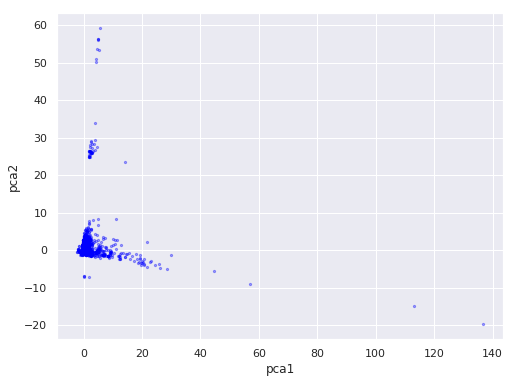

In [ ]:
def var_scatter(df):
    ax=None
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x="pca1" , y="pca2", alpha=0.35, s=5, ax=ax, c = "blue")

    return ax

var_scatter(pcatdmNameClsDf);

In [ ]:
clustering_kmeans = KMeans(n_clusters=4, precompute_distances="auto", n_jobs=-1)
pcatdmNameClsDf['clusters'] = clustering_kmeans.fit_predict(pcatdmNameClsDf)

In [ ]:
pcatdmNameClsDf.head()

,pca1,pca2,clusters
0,-0.477943,-0.385944,3
1,-0.558203,-0.499261,3
2,-0.422615,-0.400815,3
3,-0.033680,1.824356,3
4,-0.558203,-0.499261,3


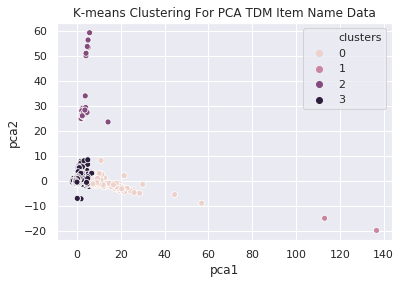

In [ ]:
sns.scatterplot(x="pca1", y="pca2", hue=pcatdmNameClsDf['clusters'], data=pcatdmNameClsDf)
plt.title('K-means Clustering For PCA TDM Item Name Data')
plt.show()

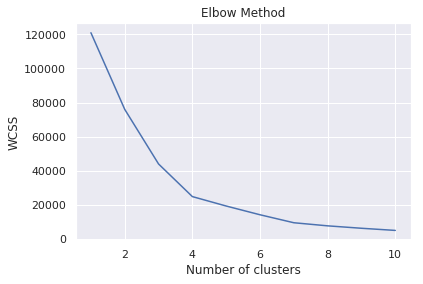

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pcatdmNameClsDf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

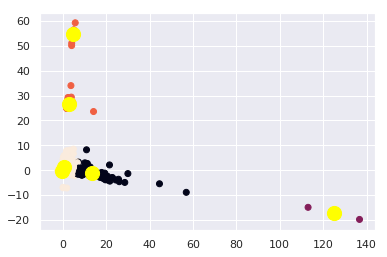

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(pcatdmNameClsDf)
plt.scatter(x="pca1", y="pca2", c=pcatdmNameClsDf['clusters'], data=pcatdmNameClsDf)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='yellow')
plt.show()

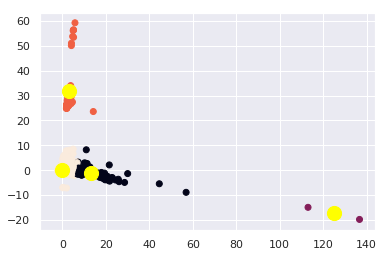

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(pcatdmNameClsDf)
plt.scatter(x="pca1", y="pca2", c=pcatdmNameClsDf['clusters'], data=pcatdmNameClsDf)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='yellow')
plt.show()

## **Cluster Analysis of TF-IDF Data of Item Name**




In [ ]:
tfidfItemNameStr1TF1DF.head()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,backup-camera,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,chalet,chevy-210,chevy-ajax,chevy-astro,chevy-beretta,chevy-blazer,chevy-c/k,chevy-camaro,chevy-cameo,chevy-caprice,chevy-cavalier,chevy-celta,chevy-chevelle,...,ranch-style,rear-spoiler,regular-floor-mats,roll-bar,roll-cage,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-land-cruiser,toyota-porte,toyota-prius,toyota-tacoma,toyota-tundra,toyota-voxy,trek,ultramarine,vehicle-cover,wheelchair-ramp,wnd,worksman-cycles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503993,0.0


In [ ]:
tfidfItemNameStr1TF1DF.shape

(13518, 250)

#Feature Scaling - Normalization

Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated.

In [ ]:
from sklearn.preprocessing import StandardScaler
sctfidfStr1Tf1DFIName = StandardScaler().fit_transform(tfidfItemNameStr1TF1DF)
sctfidfStr1Tf1DFIName

array([[-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
        -2.44481011, -3.22295041],
       [-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
        -2.44481011, -3.22295041],
       [-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
         0.69966379, -3.22295041],
       ...,
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786],
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786],
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786]])

#PCA Analysis

##PCA Analysis of TFIDF Item Name data

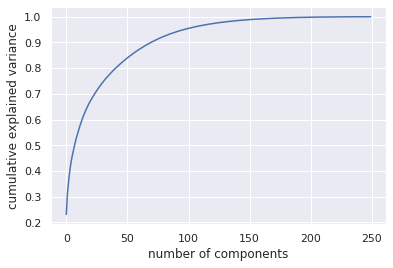

In [ ]:
#plot cumulative explained variance and number of components ratio
pca = PCA().fit(sctfidfStr1Tf1DFIName)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=0.90)
principalComponents = pca.fit_transform(sctfidfStr1Tf1DFIName)
#np.sum(pca.explained_variance_ratio_)
pca.n_components_

71

##PCA Analysis with 90% data or PCA with 71 Components

In [ ]:
pca = PCA(n_components=71)
principalComponents = pca.fit_transform(sctfidfStr1Tf1DFIName)
PCtfidfDFIName = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28', 'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35', 'pca36', 'pca37', 'pca38', 'pca39', 'pca40','pca41', 'pca42', 'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49', 'pca50','pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56', 'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63', 'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70','pca71'])

In [ ]:
PCtfidfDFIName

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69,pca70,pca71
0,29.378259,24.990501,12.614054,17.427820,4.915290,7.168851,3.327827,2.379876,2.452258,15.742448,-1.338879,1.118641,4.221702,3.067469,-5.194342,7.789261,2.031766,-0.001936,3.351416,-2.697487,-0.023561,0.242291,-0.129946,0.296793,7.395842,-0.354694,2.071081,1.246787,4.091987,0.727524,0.895892,0.225225,-0.182249,0.686419,2.842860,4.976534,0.025345,5.505468,0.286477,-2.432477,3.364961,-0.944166,1.146260,2.199026,0.284281,0.209719,3.020401,-1.564278,-0.595978,0.648689,-0.008028,-1.693254,-2.350448,0.056035,-0.153527,-1.226439,0.243158,0.329148,1.630310,1.683652,-2.011020,-2.434912,-0.323788,2.292519,-3.084651,-0.848570,0.277193,-1.620297,0.045293,2.291720,-2.021766
1,28.498698,25.202096,12.619399,17.174408,4.556631,7.522470,3.431804,2.280040,2.796937,16.707983,-1.372315,1.095391,4.753418,3.309631,-5.118934,7.840859,2.630877,0.243378,3.636291,-2.286346,-0.612260,-0.349219,-0.229153,-0.007527,7.080260,0.327286,1.994369,1.959925,3.040245,-0.884973,1.030094,1.151880,-0.357320,0.262993,1.939592,5.793510,-0.412737,5.020628,-0.078123,-2.180415,3.085572,-0.098422,1.304478,0.941822,1.682150,-0.223119,2.281586,-1.546763,0.208180,-0.072832,-1.238190,-1.217793,-2.057753,-0.971984,0.324192,-0.689772,1.323548,-1.305499,3.848789,2.167049,-1.332117,-0.276845,-0.423864,0.780833,-1.231744,-0.839614,0.202166,-0.750781,0.773310,1.461304,-0.082545
2,28.577395,25.265100,12.762954,16.723004,4.268917,7.967009,2.888877,1.706131,3.210158,16.556328,-1.893652,0.472809,4.244634,3.613156,-3.878946,7.469584,3.288671,0.177131,3.403231,-2.493931,-1.056826,-0.556490,-0.161039,0.555477,7.448919,0.471852,1.381240,1.951830,2.768332,-0.593859,1.750958,0.901483,-0.587785,0.130143,2.030848,6.005908,-0.333203,5.034528,0.423071,-2.060890,3.351996,-0.314337,1.131205,0.769966,2.334471,0.096198,0.971262,0.188852,-0.090565,0.868147,0.257923,-0.405739,-1.859725,-0.644492,0.198960,-0.259350,0.882580,-2.184600,3.299343,2.873385,-0.927382,0.469332,-0.631561,0.536464,-1.292144,-1.304437,0.980214,-1.144559,0.455109,1.133109,-0.009485
3,28.626356,25.214998,12.621550,16.549274,4.628075,8.381411,3.119345,1.404604,2.729905,15.923531,-1.608088,1.280457,3.775875,3.477445,-3.733379,6.878320,3.209656,0.194166,3.129493,-2.295288,-1.233559,-1.257314,-0.753978,1.443041,7.554870,0.282275,0.781911,2.204591,2.262680,-0.654555,1.425249,1.324874,0.343826,1.497910,1.011844,7.605283,0.610769,4.100712,0.656631,-2.087835,2.995377,0.473111,0.438061,1.095126,2.467298,-0.362164,0.862786,0.449485,-0.630008,-0.057645,0.612156,-0.095692,-1.677149,0.330187,-0.802179,-1.269423,1.307183,-1.602446,3.263798,0.621219,-0.788717,0.985138,-0.361464,-0.285353,-0.962927,-1.588103,0.758732,-1.168760,-0.256955,1.856630,0.010349
4,28.626356,25.214998,12.621550,16.549274,4.628075,8.381411,3.119345,1.404604,2.729905,15.923531,-1.608088,1.280457,3.775875,3.477445,-3.733379,6.878320,3.209656,0.194166,3.129493,-2.295288,-1.233559,-1.257314,-0.753978,1.443041,7.554870,0.282275,0.781911,2.204591,2.262680,-0.654555,1.425249,1.324874,0.343826,1.497910,1.011844,7.605283,0.610769,4.100712,0.656631,-2.087835,2.995377,0.473111,0.438061,1.095126,2.467298,-0.362164,0.862786,0.449485,-0.630008,-0.057645,0.612156,-0.095692,-1.677149,0.330187,-0.802179,-1.269423,1.307183,-1.602446,3.263798,0.621219,-0.788717,0.985138,-0.361464,-0.285353,-0.962927,-1.588103,0.758732,-1.168760,-0.256955,1.856630,0.010349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
pca.explained_variance_ratio_

array([0.23088402, 0.08590842, 0.04844985, 0.04041608, 0.03112858,
       0.02491839, 0.02247945, 0.02086829, 0.01946899, 0.01670626,
       0.01666438, 0.01531999, 0.01413774, 0.01376382, 0.01291279,
       0.01161886, 0.0109237 , 0.01080771, 0.00946803, 0.00937058,
       0.00850385, 0.00823837, 0.0078358 , 0.00765643, 0.00747905,
       0.00733904, 0.00703356, 0.00679608, 0.00655738, 0.00640357,
       0.00612016, 0.00585208, 0.00575805, 0.00555293, 0.0052914 ,
       0.00521389, 0.00513293, 0.00501333, 0.00496628, 0.00486103,
       0.00457388, 0.00456642, 0.0044756 , 0.00426565, 0.00424881,
       0.0041934 , 0.00411317, 0.00403642, 0.00395511, 0.00387503,
       0.00379426, 0.00374074, 0.00370509, 0.00365397, 0.00346386,
       0.00345209, 0.00332555, 0.00324118, 0.00321183, 0.00320205,
       0.00309245, 0.00303855, 0.00299447, 0.0029228 , 0.00287489,
       0.00281061, 0.00273412, 0.00259216, 0.00254349, 0.00248896,
       0.00248186])

  * Plot PCA Variance for 71 components

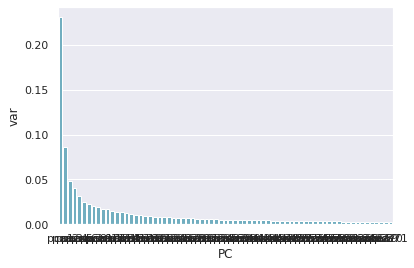

In [ ]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28', 'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35', 'pca36', 'pca37', 'pca38', 'pca39', 'pca40','pca41', 'pca42', 'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49', 'pca50','pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56', 'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63', 'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70','pca71']})
sns.barplot(x='PC',y="var",
           data=df, color="c");

# **Silhouette Analysis**

**Selecting the number of clusters with silhouette analysis on KMeans clustering**

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

The coefficient combines the average within-cluster distance with average nearest-cluster distance to assign a value between -1 and 1. A value below zero denotes that the observation is probably in the wrong cluster and a value closer to 1 denotes that the observation is a great fit for the cluster and clearly separated from other clusters. This coefficient essentially measures how close an observation is to neighboring clusters, where it is desirable to be the maximum distance possible from neighboring clusters.

  * Silhouette Analysis with TFIDF Item Name data

In [ ]:
tfidfItemNameStr1TF1DF.describe()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,backup-camera,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,chalet,chevy-210,chevy-ajax,chevy-astro,chevy-beretta,chevy-blazer,chevy-c/k,chevy-camaro,chevy-cameo,chevy-caprice,chevy-cavalier,chevy-celta,chevy-chevelle,...,ranch-style,rear-spoiler,regular-floor-mats,roll-bar,roll-cage,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-land-cruiser,toyota-porte,toyota-prius,toyota-tacoma,toyota-tundra,toyota-voxy,trek,ultramarine,vehicle-cover,wheelchair-ramp,wnd,worksman-cycles
count,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,...,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000
mean,0.462699,0.556516,0.536020,0.534976,0.587988,0.633888,0.539433,0.330249,0.578658,0.676488,0.523083,0.694253,0.472596,0.515523,0.547385,0.546193,0.743471,0.489944,0.458101,0.451109,0.775984,0.650545,0.592998,0.528315,0.470514,0.526267,0.547760,0.504606,0.653800,0.941046,0.523047,0.619537,0.668587,0.564816,0.673767,0.278068,0.722115,0.643878,0.077556,0.641169,...,0.521401,0.539961,0.537553,0.571950,0.688331,0.626286,0.391075,0.585910,0.663791,0.227489,0.916102,0.503869,0.430336,0.639327,0.529570,0.531599,0.490800,0.430688,0.400503,0.600223,0.636746,0.603017,0.582970,0.624067,0.577830,0.584659,0.615616,0.701579,0.555815,0.582846,0.945868,0.630456,0.623645,0.567860,0.025037,0.650321,0.542070,0.530075,0.391852,0.529341
std,0.263316,0.183038,0.148424,0.175342,0.152716,0.259514,0.154036,0.150114,0.158553,0.345101,0.177321,0.418222,0.096283,0.138224,0.216165,0.180194,0.268102,0.143339,0.355516,0.147631,0.153011,0.265202,0.194978,0.292861,0.148317,0.155685,0.197898,0.240040,0.161750,0.120777,0.497384,0.206770,0.195103,0.364648,0.171261,0.335120,0.169093,0.185598,0.228130,0.196768,...,0.178397,0.154518,0.334296,0.175059,0.204629,0.173868,0.145845,0.166675,0.404511,0.301221,0.198208,0.163786,0.100292,0.149292,0.155146,0.146913,0.143163,0.295071,0.282295,0.179980,0.184896,0.181865,0.172642,0.217540,0.195503,0.191136,0.209260,0.317764,0.374211,0.389642,0.159526,0.184302,0.207641,0.198313,0.107549,0.177392,0.141863,0.207974,0.160285,0.164247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.565763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
from sklearn.preprocessing import StandardScaler
sctfidfStr1TF1DFIName = StandardScaler().fit_transform(tfidfItemNameStr1TF1DF)
sctfidfStr1TF1DFIName

array([[-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
        -2.44481011, -3.22295041],
       [-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
        -2.44481011, -3.22295041],
       [-1.75726785, -3.04055979, -3.61153087, ..., -2.54884975,
         0.69966379, -3.22295041],
       ...,
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786],
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786],
       [-0.39550133,  0.74182029, -1.36022834, ..., -0.28311412,
         0.65864655,  0.96197786]])

  * TFIDF TCA explained_variance_ratio_ Analysis

In [ ]:
pca = PCA(n_components=71)
principalComponents = pca.fit_transform(sctfidfStr1Tf1DFIName)
np.sum(pca.explained_variance_ratio_)

0.9015499600037267

In [ ]:
pca.explained_variance_ratio_

array([0.23088402, 0.08590842, 0.04844985, 0.04041608, 0.03112858,
       0.02491839, 0.02247945, 0.02086829, 0.01946899, 0.01670626,
       0.01666438, 0.01531999, 0.01413774, 0.01376382, 0.01291279,
       0.01161886, 0.0109237 , 0.01080771, 0.00946803, 0.00937059,
       0.00850386, 0.00823836, 0.00783579, 0.00765642, 0.00747907,
       0.00733905, 0.00703354, 0.00679609, 0.00655738, 0.00640348,
       0.00612022, 0.00585244, 0.00575811, 0.00555304, 0.00529136,
       0.00521379, 0.00513308, 0.005014  , 0.00496717, 0.00486156,
       0.00457432, 0.00456805, 0.00447627, 0.00426626, 0.00424714,
       0.00419348, 0.00411284, 0.00403714, 0.0039563 , 0.00387375,
       0.00379577, 0.0037305 , 0.00370947, 0.00365768, 0.0034676 ,
       0.00345981, 0.00332731, 0.00324475, 0.00320837, 0.00319909,
       0.00309425, 0.00302815, 0.00300207, 0.00293389, 0.0028866 ,
       0.00281349, 0.00274265, 0.00260279, 0.00256124, 0.00250907,
       0.0024461 ])

  * Silhoutte Result Data with various PCA components

In [ ]:
SilResultDF = pd.DataFrame(columns = ['PCAComponents', 'Cls2SilScore', 'Cls2Centroids','Cls3SilScore', 'Cls3Centroids','Cls4SilScore', 'Cls4Centroids','Cls5SilScore', 'Cls5Centroids','Cls6SilScore', 'Cls6Centroids','Cls7SilScore', 'Cls7Centroids','Cls8SilScore', 'Cls8Centroids','Cls9SilScore', 'Cls9Centroids','Cls10SilScore', 'Cls10Centroids'])

In [ ]:
SilResultDF.insert(1, "PCAVarRatio", [0.90], True)

In [ ]:
SilResultDF

,PCAComponents,Cls2SilScore,Cls2Centroids,Cls3SilScore,Cls3Centroids,Cls4SilScore,Cls4Centroids,Cls5SilScore,Cls5Centroids,Cls6SilScore,Cls6Centroids,Cls7SilScore,Cls7Centroids,Cls8SilScore,Cls8Centroids,Cls9SilScore,Cls9Centroids,Cls10SilScore,Cls10Centroids


##Silhoutte Analysis Result Matrix
  * Save Silhoutte Result data into file

In [ ]:
SilResultDF.to_excel('/content/gdrive/My Drive/CAPSTONE Project: Data Pirates/SilResultTF1.xlsx')

In [ ]:
loadSilResult = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/SilResultTF1.xlsx')
loadSilResultDF = pd.DataFrame(loadSilResult, columns= loadSilResult.columns)

In [ ]:
loadSilResultDF.head(10)

,Unnamed: 0,PCAComponents,PCAVarRatio,Cls2SilScore,Cls2Centroids,Cls3SilScore,Cls3Centroids,Cls4SilScore,Cls4Centroids,Cls5SilScore,Cls5Centroids,Cls6SilScore,Cls6Centroids,Cls7SilScore,Cls7Centroids,Cls8SilScore,Cls8Centroids,Cls9SilScore,Cls9Centroids,Cls10SilScore,Cls10Centroids
0,0,2,0.35,0.700904,"[[-1.1344005942039432, 0.08547931275068284], [...",0.697956,"[[3.6123736954489623, -2.4589567735061655], [-...",0.692564,"[[-1.625844313203164, 0.6490417850436795], [1....",0.488812,"[[-1.2169143852466564, 1.362670594479129], [6....",0.489209,"[[-1.9354194187545843, 0.10131594633680933], [...",0.512772,"[[0.29065996676856376, 0.20146714451454883], [...",0.510450,"[[-1.9371931624264649, 0.09508419631094656], [...",0.510813,"[[-1.4309353377319023, 1.4871061278451196], [4...",0.455046,"[[6.601420115270316, -2.7766087586271295], [-2..."
1,1,5,0.50,0.549077,"[[-1.1240603146636154, 0.0808115848614009], [7...",0.470069,"[[3.5698021122484755, -2.443820305411198], [-1...",0.422419,"[[-1.703596944993254, 0.6714109048591737], [1....",0.356629,"[[-1.6573422521663206, 0.725248693566719], [1....",0.400263,"[[-1.4927064676344797, 1.3871678495494892], [-...",0.387495,"[[-0.8281669335853368, 1.0243097648851176], [6...",0.387577,"[[-1.4109760827555529, 1.789978722250847], [6....",0.370935,"[[4.339479329987072, -2.1603860203349585], [-2...",0.376122,"[[-2.0730372184374053, 0.6239882664843209], [8..."
2,2,10,0.66,0.454304,"[[7.107276559061962, -0.5109450862987774], [-1...",0.352427,"[[-1.6163867524275735, 0.6435950650296209], [3...",0.311662,"[[6.650233683092561, -2.096616621012544], [-1....",0.246260,"[[-1.6519093260523159, 0.7863520827163576], [6...",0.261839,"[[-1.778237665847493, 0.8773242419545008], [1....",0.286718,"[[-1.7910075261861227, 0.2706833581476457], [6...",0.287195,"[[-1.7392645749782916, 0.8179106925953693], [1...",0.305435,"[[-2.0650615642574435, 0.6111103613801208], [1...",0.302534,"[[-1.7604753671775253, 0.5948587792207858], [7..."
3,3,16,0.79,0.398327,"[[-1.124060408740806, 0.0808095274127969], [7....",0.290555,"[[-1.6157780877474597, 0.643525468167835], [3....",0.246974,"[[1.5896983313368094, -2.5821166849188772], [-...",0.184977,"[[1.595385174669029, -2.603302919681846], [-1....",0.239666,"[[-1.904922456767094, 0.4434137164687528], [1....",0.213624,"[[6.650233098398774, -2.0965952655239515], [-2...",0.208551,"[[-1.7260742972384875, 0.49968613826854635], [...",0.226210,"[[-1.7903926416417073, 0.23784444357169363], [...",0.214379,"[[1.296442069162322, -2.7338308547853645], [-2..."
4,4,20,0.86,0.374843,"[[-1.1240604265655838, 0.08080849456430698], [...",0.196844,"[[-1.7229168914317574, 0.6688631503935705], [7...",0.219657,"[[-1.6315025813011672, 0.6501070643110656], [1...",0.166470,"[[-1.6473080035878696, 0.7755365205562009], [1...",0.212435,"[[-1.9082261702672567, 0.43845528807457185], [...",0.183587,"[[-0.5174514009099127, 0.4665587543938792], [-...",0.188737,"[[-2.0644536530648163, 0.6931419403510017], [1...",0.183234,"[[-1.4160819784529226, 1.843035198941935], [-1...",0.211869,"[[6.650233196581819, -2.0965920040698784], [-2..."
5,5,23,0.91,0.362872,"[[-1.1240604268674752, 0.0808085070614171], [7...",0.252851,"[[-1.6157780841463063, 0.6435255570117875], [3...",0.208690,"[[1.624939198295348, -2.5815142361638395], [-1...",0.156145,"[[6.706481775234221, -2.08649318211306], [-1.6...",0.163937,"[[-1.886337242168677, 0.7045555275552566], [1....",0.165229,"[[-0.6776155435713539, 0.9316156522099482], [6...",0.172250,"[[-0.695141859213841, 0.9409921268309074], [6....",0.180756,"[[-1.416081951377633, 1.843034522223834], [-1....",0.174644,"[[-1.6952855405754845, 0.8393934734724418], [4..."


##PCA Analysis using 71 components (90% of TFIDF Data)

In [ ]:
pca = PCA(n_components=71)
principalComponents = pca.fit_transform(sctfidfStr1TF1DFIName)
pcatfidfStr1TF1DFIName = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28', 'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35', 'pca36', 'pca37', 'pca38', 'pca39', 'pca40','pca41', 'pca42', 'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49', 'pca50','pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56', 'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63', 'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70','pca71'])

  * Calculate avg. silhoutte scores for a cluster range from 2-10
  * The silhouette plot for the various clusters
  * The silhouette coefficient values
  * Cluster labels
  * Centroid calculation for each clusters
  * save the result in dataframe

**Analysis from the above Silhoutte Analysis:**
In this above the silhouette analysis is used to choose an optimal value for number of clusters (n_clusters). The silhouette plot shows that the n_clusters value of 2 and 6 are a bad pick for the given data due to the presence of clusters with below or very close to average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 5, 7, 8, 9 and 10.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 and 1 when n_clusters is equal to 3, is bigger in size owing to the grouping of the 4 sub clusters into one big cluster. However when the n_clusters is equal to 10, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right. 10 clusters also gives 2 uniqueclusters with high sillhouette scores and majority of the clusters give silhouette scores above average value.

---------------------------------------------------------------------

The average silhouette scores :
For clusterVal = 2 The average silhouette_score is : 0.29035471547519504

The cluster level silhouette scores of  2  clusters: 
For clusterVal =  0 The size of cluster :  10218 , Minimum Silhouette Value =  0.11319417421689795 , Maximum Silhouette Value =  0.40460070354636557
For clusterVal =  1 The size of cluster :  3300 , Minimum Silhouette Value =  -0.11615673567584142 , Maximum Silhouette Value =  0.2207232199954768
Number of silhouette scores less than 0:  682

Positive silhouette score accuracy for  2  clusters =  0.9495487498150614
---------------------------------------------------------------------

The average silhouette scores :
For clusterVal = 3 The average silhouette_score is : 0.25215560818310795

The cluster level silhouette scores of  3  clusters: 
For clusterVal =  0 The size of cluster :  2589 , Minimum Silhouette Value =  -0.008150422096650083 , Maximum Silhouette

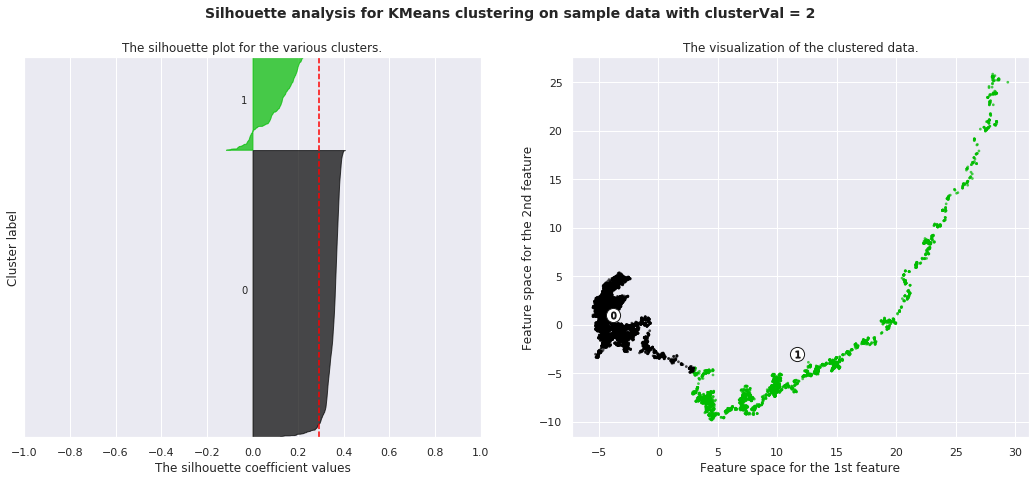

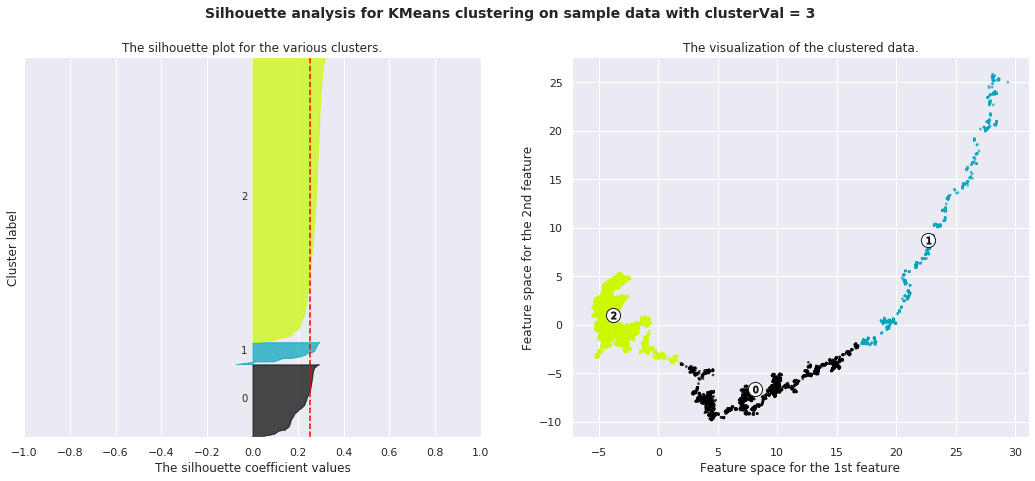

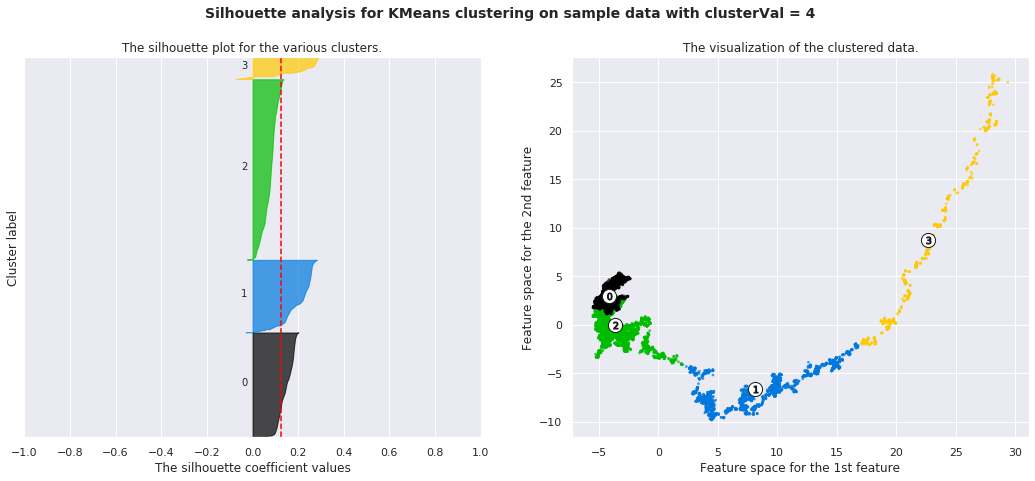

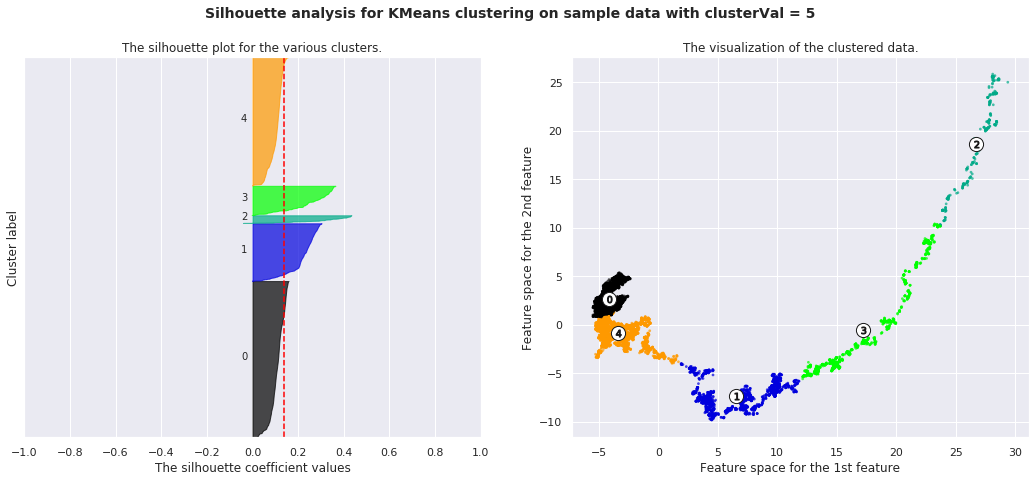

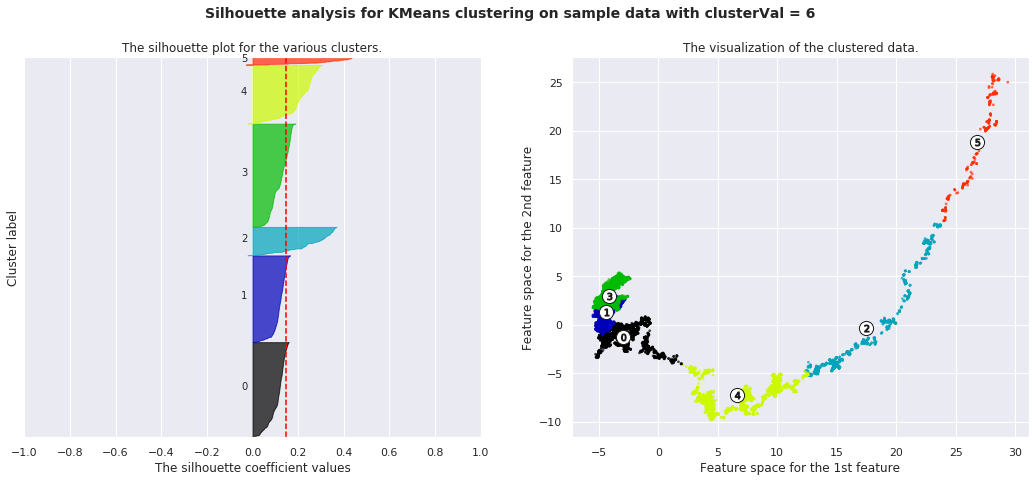

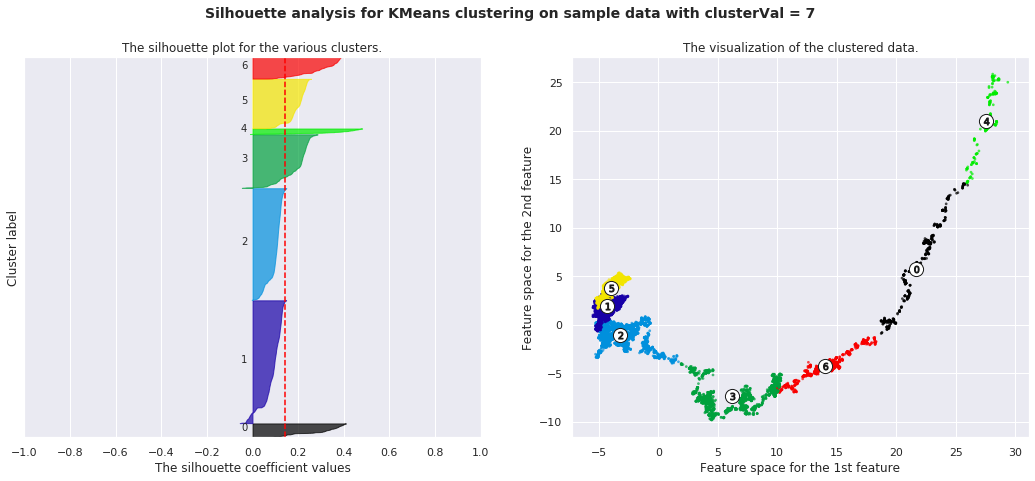

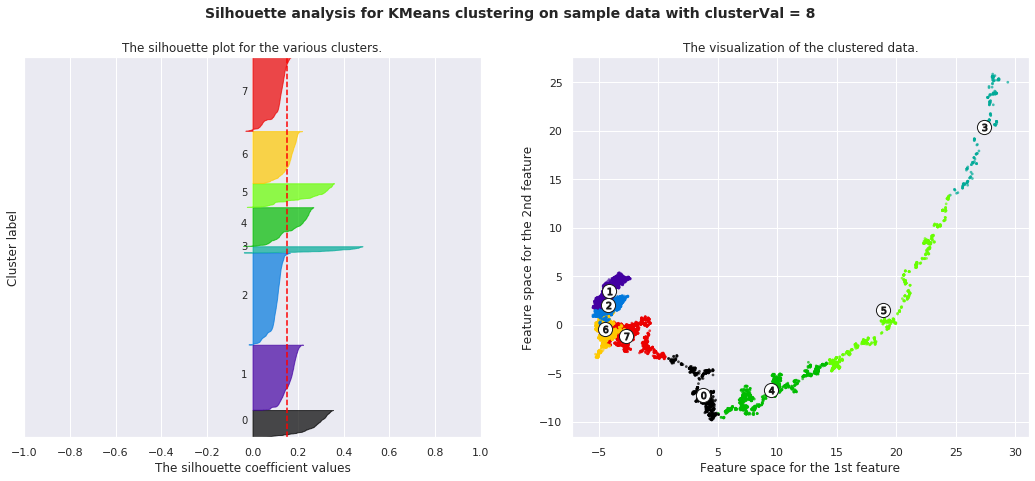

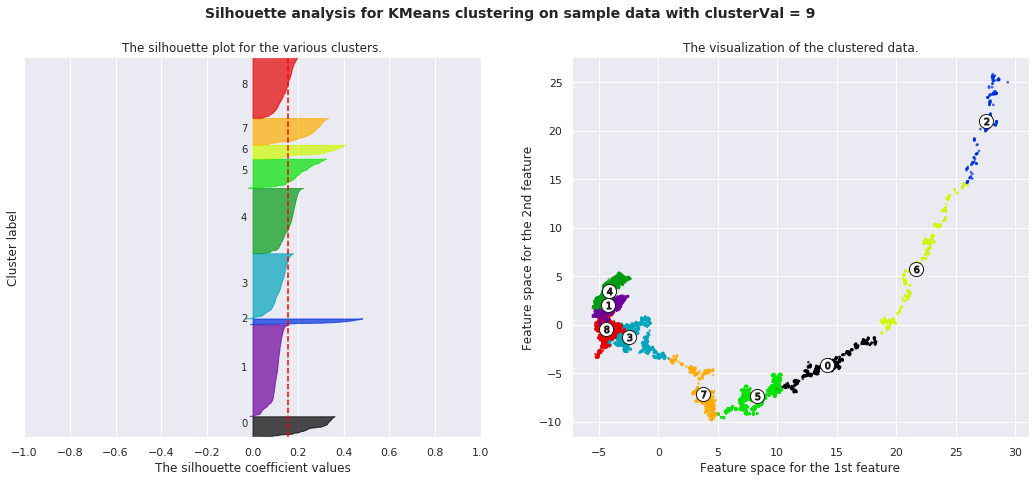

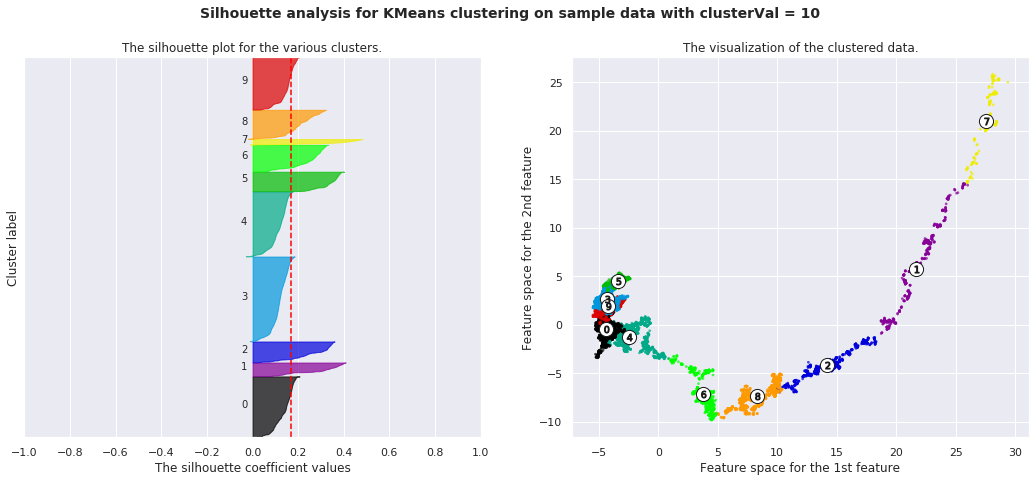

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

clusterRange = range(2,11)

for clusterVal in clusterRange:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    #The (clusterVal+1)*10 is for inserting blank space between silhouette
    #plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcatfidfStr1TF1DFIName) + (clusterVal + 1) * 10])

    #clusterer = KMeans(n_clusters=clusterVal, random_state=10)
    #cluster_labels = clusterer.fit_predict(pcatfidfStr1TF1DFIName)

    clusterer = KMeans(n_clusters=clusterVal, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pcatfidfStr1TF1DFIName)
    cluster_labels = clusterer.labels_

    #silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pcatfidfStr1TF1DFIName, cluster_labels)
    print("---------------------------------------------------------------------")
    print()
    print("The average silhouette scores :")
    print("For clusterVal =", clusterVal,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcatfidfStr1TF1DFIName, cluster_labels)

    y_lower = 10
    negativeCount =0
    print()
    print("The cluster level silhouette scores of ", clusterVal, " clusters: ")
    for i in range(clusterVal):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        print("For clusterVal = ", i,
              "The size of cluster : ", size_cluster_i,
              ", Minimum Silhouette Value = ", ith_cluster_silhouette_values[0],
              ", Maximum Silhouette Value = ", ith_cluster_silhouette_values[size_cluster_i-1])
        if ith_cluster_silhouette_values[0] < 0:
            print("Number of silhouette scores less than 0: ", len(ith_cluster_silhouette_values[ith_cluster_silhouette_values<0]))
            negativeCount = negativeCount+len(ith_cluster_silhouette_values[ith_cluster_silhouette_values<0])



        color = cm.nipy_spectral(float(i) / clusterVal)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    print()
    print("Positive silhouette score accuracy for ", clusterVal, " clusters = ", (sample_silhouette_values.shape[0]-negativeCount)/sample_silhouette_values.shape[0])
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusterVal)
    ax2.scatter(pcatfidfStr1TF1DFIName['pca1'], pcatfidfStr1TF1DFIName['pca2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with clusterVal = %d" % clusterVal),
                 fontsize=14, fontweight='bold')


plt.show()

The average silhouette scores :
For clusterVal = 5 The average silhouette_score is : 0.13658177669069446

The cluster level silhouette scores of  5  clusters: 
For clusterVal =  0 The size of cluster :  6419 , Minimum Silhouette Value =  -0.024317813322771678 , Maximum Silhouette Value =  0.13594718745135212
Number of silhouette scores less than 0:  29
For clusterVal =  1 The size of cluster :  2093 , Minimum Silhouette Value =  -0.006125142565180476 , Maximum Silhouette Value =  0.30878897700871855
Number of silhouette scores less than 0:  1
For clusterVal =  2 The size of cluster :  1008 , Minimum Silhouette Value =  -0.020373803641318175 , Maximum Silhouette Value =  0.3701373251880223
Number of silhouette scores less than 0:  4
For clusterVal =  3 The size of cluster :  270 , Minimum Silhouette Value =  -0.02870333430097451 , Maximum Silhouette Value =  0.43744493023429976
Number of silhouette scores less than 0:  6
For clusterVal =  4 The size of cluster :  3728 , Minimum Silhouet

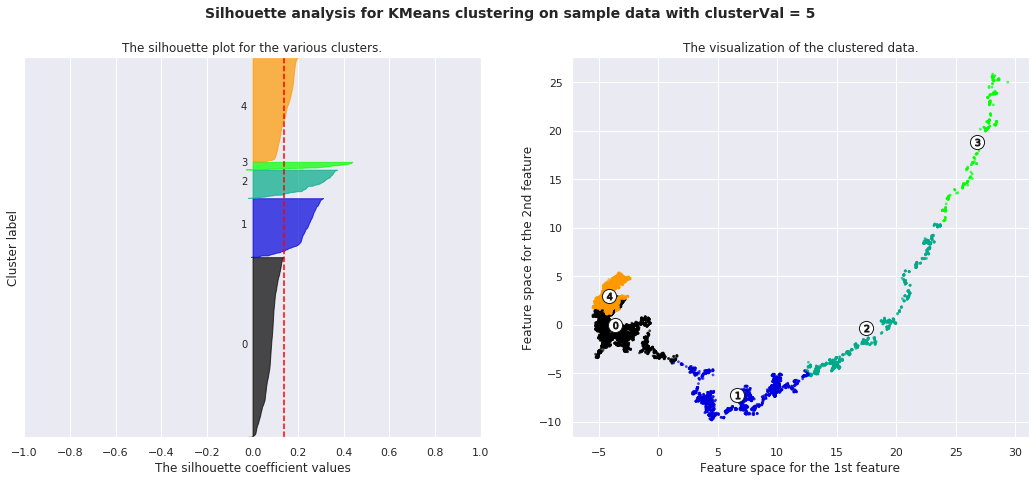

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

clusterRange = range(5,6)

for clusterVal in clusterRange:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    # The (clusterVal+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcatfidfStr1TF1DFIName) + (clusterVal + 1) * 10])

    #clusterer = KMeans(n_clusters=clusterVal, random_state=10)
    #cluster_labels = clusterer.fit_predict(pcatfidfStr1TF1DFIName)

    clusterer = KMeans(n_clusters=clusterVal, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pcatfidfStr1TF1DFIName)
    cluster_labels = clusterer.labels_

    #silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pcatfidfStr1TF1DFIName, cluster_labels)
    print("The average silhouette scores :")
    print("For clusterVal =", clusterVal,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcatfidfStr1TF1DFIName, cluster_labels)

    y_lower = 10
    negativeCount =0
    print()
    print("The cluster level silhouette scores of ", clusterVal, " clusters: ")
    for i in range(clusterVal):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        print("For clusterVal = ", i,
              "The size of cluster : ", size_cluster_i,
              ", Minimum Silhouette Value = ", ith_cluster_silhouette_values[0],
              ", Maximum Silhouette Value = ", ith_cluster_silhouette_values[size_cluster_i-1])
        if ith_cluster_silhouette_values[0] < 0:
            print("Number of silhouette scores less than 0: ", len(ith_cluster_silhouette_values[ith_cluster_silhouette_values<0]))
            negativeCount = negativeCount+len(ith_cluster_silhouette_values[ith_cluster_silhouette_values<0])



        color = cm.nipy_spectral(float(i) / clusterVal)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    print()
    print("Positive silhouette score accuracy for ", clusterVal, " clusters = ", (sample_silhouette_values.shape[0]-negativeCount)/sample_silhouette_values.shape[0])
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusterVal)
    ax2.scatter(pcatfidfStr1TF1DFIName['pca1'], pcatfidfStr1TF1DFIName['pca2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with clusterVal = %d" % clusterVal),
                 fontsize=14, fontweight='bold')

    if clusterVal == 5:
      cl1 = [centers[:, 0][0], centers[:, 1][0]]
      cl2 = [centers[:, 0][1], centers[:, 1][1]]
      cl3 = [centers[:, 0][2], centers[:, 1][2]]
      cl4 = [centers[:, 0][3], centers[:, 1][3]]
      cl5 = [centers[:, 0][4], centers[:, 1][4]]
      coordinate = [cl1,cl2,cl3,cl4,cl5]
      print("In cluster 5: Cluster Coordinates::")
      print(coordinate)


plt.show()

###TF1 Cluster analysis with 5 clusters using KMeans

In [ ]:
clustering_kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pcatfidfStr1TF1DFIName['clusters'] = clustering_kmeans.fit_predict(pcatfidfStr1TF1DFIName)

#kmeans5ClsTF1 = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
#pred_y = kmeans5ClsTF1.fit_predict(pcatfidfStr1TF1DFIName)
#plt.scatter(x="pca1", y="pca2", c=pcatfidfStr1TF1DFIName['clusters'], data=pcatfidfStr1TF1DFIName, s=80, marker='.')
#plt.show()

In [ ]:
#check PCA TFIDF Data description with cluster information
pcatfidfStr1TF1DFIName.describe()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69,pca70,pca71,clusters
count,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,1.351800e+04,13518.000000
mean,1.721889e-14,-9.924694e-15,-4.171771e-15,-4.411983e-16,4.453704e-16,1.480306e-15,-2.915916e-16,-4.135371e-16,-3.141279e-16,-6.076557e-16,5.446811e-17,-2.516276e-16,-2.670514e-16,-5.934125e-16,4.153111e-16,5.492311e-16,-6.542415e-17,3.853432e-16,-1.857014e-16,-5.790111e-16,-4.335602e-16,1.166235e-17,-3.418876e-16,-6.149837e-17,6.042248e-16,4.937774e-16,4.476865e-16,-4.626052e-16,9.101891e-16,4.621741e-16,1.556246e-16,5.078379e-16,2.501862e-18,-3.318021e-17,1.225820e-16,1.321028e-16,5.607784e-17,-3.276464e-16,-6.827855e-16,-9.455785e-16,-1.084525e-15,1.804872e-16,-2.341472e-15,-3.741315e-16,1.233975e-15,6.137107e-16,-3.870587e-16,6.011860e-16,-8.268854e-16,-4.236062e-16,-6.135875e-17,-7.974277e-16,8.676810e-16,9.952257e-16,-1.286472e-16,4.967423e-16,-2.126285e-16,-1.110059e-15,6.156900e-16,3.325577e-16,-1.967416e-16,-6.948832e-16,-3.959163e-16,1.090430e-16,-1.087950e-15,-1.581711e-15,-5.353348e-16,1.001311e-15,-1.152881e-15,-1.305748e-15,-1.034943e-15,1.779923
std,7.597715e+00,4.634511e+00,3.480425e+00,3.178800e+00,2.789753e+00,2.496008e+00,2.370713e+00,2.284175e+00,2.206266e+00,2.043740e+00,2.041177e+00,1.957111e+00,1.880079e+00,1.855050e+00,1.796785e+00,1.704385e+00,1.652612e+00,1.643815e+00,1.538565e+00,1.530627e+00,1.458122e+00,1.435181e+00,1.399676e+00,1.383563e+00,1.367440e+00,1.354576e+00,1.326094e+00,1.303513e+00,1.280416e+00,1.265283e+00,1.236984e+00,1.209628e+00,1.199846e+00,1.178288e+00,1.150163e+00,1.141712e+00,1.132829e+00,1.119573e+00,1.114357e+00,1.102467e+00,1.069342e+00,1.068692e+00,1.057748e+00,1.032747e+00,1.030617e+00,1.023927e+00,1.014083e+00,1.004539e+00,9.946256e-01,9.838917e-01,9.733022e-01,9.677488e-01,9.622152e-01,9.559235e-01,9.308180e-01,9.303123e-01,9.120331e-01,8.989495e-01,8.950000e-01,8.921646e-01,8.790473e-01,8.681850e-01,8.638911e-01,8.564395e-01,8.486831e-01,8.331727e-01,8.259632e-01,8.033628e-01,8.023643e-01,7.925112e-01,7.861561e-01,1.784297
min,-5.501056e+00,-9.840875e+00,-6.923803e+00,-8.580606e+00,-5.835505e+00,-7.092706e+00,-5.014934e+00,-4.751912e+00,-4.830679e+00,-9.670707e+00,-4.039458e+00,-4.831217e+00,-4.859670e+00,-5.686675e+00,-5.554190e+00,-4.851804e+00,-5.072709e+00,-4.458478e+00,-4.424037e+00,-4.759236e+00,-4.488693e+00,-4.201978e+00,-3.629634e+00,-4.853326e+00,-4.046219e+00,-4.206226e+00,-3.764291e+00,-3.684849e+00,-3.964013e+00,-3.545380e+00,-3.738527e+00,-4.102445e+00,-3.952271e+00,-3.880738e+00,-3.837559e+00,-3.724417e+00,-3.482249e+00,-3.709001e+00,-3.590896e+00,-2.890354e+00,-4.026208e+00,-3.644227e+00,-3.855700e+00,-3.178945e+00,-3.846080e+00,-3.277005e+00,-3.749994e+00,-3.413589e+00,-3.402725e+00,-3.225047e+00,-3.589129e+00

In [ ]:
itemNameDataStr1TF1.head()

,StoreID,PeriodID,TicketID,ItemName,Sales
0,1,20180801,1,Chevy-Ajax,499
1,1,20180801,2,Chevy-Spark,499
2,1,20180801,3,Chevy-Colorado Chevy-Gemini WND WND,1478
3,1,20180801,4,Luxury-Package Apple Apple Ford-Expedition Bos...,1705
4,1,20180801,5,Chevy-Spark,499


N represents the number of clusters. Here N = 5

In [ ]:
itemNameNclsStr1Tf1DF= itemNameDataStr1TF1

In [ ]:
itemNameNclsStr1Tf1DF['clusters'] = pcatfidfStr1TF1DFIName['clusters']

In [ ]:
#ItemName Data with 2 Cluster Analysis
itemNameNclsStr1Tf1DF.describe()

,StoreID,PeriodID,TicketID,Sales,clusters
count,13518.0,1.351800e+04,13518.000000,13518.000000,13518.000000
mean,1.0,2.018102e+07,48.561769,1592.503255,1.779923
std,0.0,1.418992e+02,31.992992,1032.600586,1.784297
min,1.0,2.018080e+07,1.000000,0.000000,0.000000
25%,1.0,2.018091e+07,23.000000,938.000000,0.000000
50%,1.0,2.018102e+07,45.000000,1398.000000,1.000000
75%,1.0,2.018112e+07,69.000000,2035.000000,4.000000
max,1.0,2.018123e+07,167.000000,50000.000000,4.000000


In [ ]:
# execute below code only to drop cluster column from dataframe
itemNameDataStr1TF1 = itemNameDataStr1TF1.drop(itemNameDataStr1TF1.columns[-1],axis=1)

#**Cluster Summary Analysis - TimeFrame 1**

  * Store ID 1 Aug - Dec 2018
  * PCA with 71 Components
  * 5 cluster recognition
  * itemNameNclsStr1Tf1DF dataframe for Analysis

##**ItemName 5 Cluster Summary Analysis**

In [ ]:
itemNameNclsS1TF1DFCls0 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 0]
itemNameNclsS1TF1DFCls1 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 1]
itemNameNclsS1TF1DFCls2 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 2]
itemNameNclsS1TF1DFCls3 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 3]
itemNameNclsS1TF1DFCls4 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 4]
#itemNameNclsS1TF1DFCls5 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 5]
#itemNameNclsS1TF1DFCls6 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 6]
#itemNameNclsS1TF1DFCls7 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 7]
#itemNameNclsS1TF1DFCls8 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 8]
#itemNameNclsS1TF1DFCls9 = itemNameNclsStr1Tf1DF[itemNameNclsStr1Tf1DF['clusters'] == 9]

In [ ]:
TotalTcktIdsNcls0 = len(itemNameNclsS1TF1DFCls0)
TotalTcktIdsNcls1 = len(itemNameNclsS1TF1DFCls1)
TotalTcktIdsNcls2 = len(itemNameNclsS1TF1DFCls2)
TotalTcktIdsNcls3 = len(itemNameNclsS1TF1DFCls3)
TotalTcktIdsNcls4 = len(itemNameNclsS1TF1DFCls4)
#TotalTcktIdsNcls5 = len(itemNameNclsS1TF1DFCls5)
#TotalTcktIdsNcls6 = len(itemNameNclsS1TF1DFCls6)
#TotalTcktIdsNcls7 = len(itemNameNclsS1TF1DFCls7)
#TotalTcktIdsNcls8 = len(itemNameNclsS1TF1DFCls8)
#TotalTcktIdsNcls9 = len(itemNameNclsS1TF1DFCls9)

TotalSalesNcls0 = itemNameNclsS1TF1DFCls0['Sales'].sum()
AvgSalesNcls0 = itemNameNclsS1TF1DFCls0['Sales'].mean()

TotalSalesNcls1 = itemNameNclsS1TF1DFCls1['Sales'].sum()
AvgSalesNcls1 = itemNameNclsS1TF1DFCls1['Sales'].mean()

TotalSalesNcls2 = itemNameNclsS1TF1DFCls2['Sales'].sum()
AvgSalesNcls2 = itemNameNclsS1TF1DFCls2['Sales'].mean()

TotalSalesNcls3 = itemNameNclsS1TF1DFCls3['Sales'].sum()
AvgSalesNcls3 = itemNameNclsS1TF1DFCls3['Sales'].mean()

TotalSalesNcls4 = itemNameNclsS1TF1DFCls4['Sales'].sum()
AvgSalesNcls4 = itemNameNclsS1TF1DFCls4['Sales'].mean()

#TotalSalesNcls5 = itemNameNclsS1TF1DFCls5['Sales'].sum()
#AvgSalesNcls5 = itemNameNclsS1TF1DFCls5['Sales'].mean()

#TotalSalesNcls6 = itemNameNclsS1TF1DFCls6['Sales'].sum()
#AvgSalesNcls6 = itemNameNclsS1TF1DFCls6['Sales'].mean()

#TotalSalesNcls7 = itemNameNclsS1TF1DFCls7['Sales'].sum()
#AvgSalesNcls7 = itemNameNclsS1TF1DFCls7['Sales'].mean()

#TotalSalesNcls8 = itemNameNclsS1TF1DFCls8['Sales'].sum()
#AvgSalesNcls8 = itemNameNclsS1TF1DFCls8['Sales'].mean()

#TotalSalesNcls9 = itemNameNclsS1TF1DFCls9['Sales'].sum()
#AvgSalesNcls9 = itemNameNclsS1TF1DFCls9['Sales'].mean()

print("PCA71 WITH 5 CLUSTER ANALYSIS")
print()
print(f" The total number of ticket ids in Cluster 1 of 10 clusters: {TotalTcktIdsNcls0}")
print(f" The total Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: ${TotalSalesNcls0}")
print(f" The avg Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: ${AvgSalesNcls0}")
print()
print(f" The total number of ticket ids in Cluster 2 of 10 clusters: {TotalTcktIdsNcls1}")
print(f" The total Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: ${TotalSalesNcls1}")
print(f" The avg Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: ${AvgSalesNcls1}")
print()
print(f" The total number of ticket ids in Cluster 3 of 10 clusters: {TotalTcktIdsNcls2}")
print(f" The total Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: ${TotalSalesNcls2}")
print(f" The avg Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: ${AvgSalesNcls2}")
print()
print(f" The total number of ticket ids in Cluster 4 of 10 clusters: {TotalTcktIdsNcls3}")
print(f" The total Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: ${TotalSalesNcls3}")
print(f" The avg Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: ${AvgSalesNcls3}")
print()
print(f" The total number of ticket ids in Cluster 5 of 10 clusters: {TotalTcktIdsNcls4}")
print(f" The total Sales Amount of Cluster 5 of 10 clusters for all Ticket IDs: ${TotalSalesNcls4}")
print(f" The avg Sales Amount of Cluster 5 of 10 clusters for all Ticket IDs: ${AvgSalesNcls4}")
"""
print()
print(f" The total number of ticket ids in Cluster 6 of 10 clusters: {TotalTcktIdsNcls5}")
print(f" The total Sales Amount of Cluster 6 of 10 clusters for all Ticket IDs: ${TotalSalesNcls5}")
print(f" The avg Sales Amount of Cluster 6 of 10 clusters for all Ticket IDs: ${AvgSalesNcls5}")
print()
print(f" The total number of ticket ids in Cluster 7 of 10 clusters: {TotalTcktIdsNcls6}")
print(f" The total Sales Amount of Cluster 7 of 10 clusters for all Ticket IDs: ${TotalSalesNcls6}")
print(f" The avg Sales Amount of Cluster 7 of 10 clusters for all Ticket IDs: ${AvgSalesNcls6}")
print()
print(f" The total number of ticket ids in Cluster 8 of 10 clusters: {TotalTcktIdsNcls7}")
print(f" The total Sales Amount of Cluster 8 of 10 clusters for all Ticket IDs: ${TotalSalesNcls7}")
print(f" The avg Sales Amount of Cluster 8 of 10 clusters for all Ticket IDs: ${AvgSalesNcls7}")
print()
print(f" The total number of ticket ids in Cluster 9 of 10 clusters: {TotalTcktIdsNcls8}")
print(f" The total Sales Amount of Cluster 9 of 10 clusters for all Ticket IDs: ${TotalSalesNcls8}")
print(f" The avg Sales Amount of Cluster 9 of 10 clusters for all Ticket IDs: ${AvgSalesNcls8}")
print()
print(f" The total number of ticket ids in Cluster 10 of 10 clusters: {TotalTcktIdsNcls9}")
print(f" The total Sales Amount of Cluster 10 of 10 clusters for all Ticket IDs: ${TotalSalesNcls9}")
print(f" The avg Sales Amount of Cluster 10 of 10 clusters for all Ticket IDs: ${AvgSalesNcls9}")
"""

PCA71 WITH 5 CLUSTER ANALYSIS

 The total number of ticket ids in Cluster 1 of 10 clusters: 5566
 The total Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: $8958355
 The avg Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: $1609.4780812073302

 The total number of ticket ids in Cluster 2 of 10 clusters: 2051
 The total Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: $3381259
 The avg Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: $1648.590443686007

 The total number of ticket ids in Cluster 3 of 10 clusters: 276
 The total Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: $403495
 The avg Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: $1461.9384057971015

 The total number of ticket ids in Cluster 4 of 10 clusters: 1042
 The total Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: $1646514
 The avg Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: $1580.147792706334

 The total number of 

'\nprint()\nprint(f" The total number of ticket ids in Cluster 6 of 10 clusters: {TotalTcktIdsNcls5}")\nprint(f" The total Sales Amount of Cluster 6 of 10 clusters for all Ticket IDs: ${TotalSalesNcls5}")\nprint(f" The avg Sales Amount of Cluster 6 of 10 clusters for all Ticket IDs: ${AvgSalesNcls5}")\nprint()\nprint(f" The total number of ticket ids in Cluster 7 of 10 clusters: {TotalTcktIdsNcls6}")\nprint(f" The total Sales Amount of Cluster 7 of 10 clusters for all Ticket IDs: ${TotalSalesNcls6}")\nprint(f" The avg Sales Amount of Cluster 7 of 10 clusters for all Ticket IDs: ${AvgSalesNcls6}")\nprint()\nprint(f" The total number of ticket ids in Cluster 8 of 10 clusters: {TotalTcktIdsNcls7}")\nprint(f" The total Sales Amount of Cluster 8 of 10 clusters for all Ticket IDs: ${TotalSalesNcls7}")\nprint(f" The avg Sales Amount of Cluster 8 of 10 clusters for all Ticket IDs: ${AvgSalesNcls7}")\nprint()\nprint(f" The total number of ticket ids in Cluster 9 of 10 clusters: {TotalTcktIdsNcl

In [ ]:
itemNamelistNCls0S1TF1List = itemNameNclsS1TF1DFCls0["ItemName"].tolist()
vocabS1C0 = set()
for documentValue in itemNamelistNCls0S1TF1List:
    vocabS1C0.update(documentValue.split())

len(vocabS1C0)
#vocab1 = list(vocab)
#vocab1

201

In [ ]:
itemNamelistNCls1S1TF1List = itemNameNclsS1TF1DFCls1["ItemName"].tolist()
vocabS1C1 = set()
for documentValue in itemNamelistNCls1S1TF1List:
    vocabS1C1.update(documentValue.split())

len(vocabS1C1)
#vocab1 = list(vocab)
#vocab1

128

In [ ]:
clsAnlysDF = pd.DataFrame(columns = ['TF', 'PCAComponents', 'NoClusters','TtlTicketIdcls1', 'TtlTicketIdcls2','TtlTicketIdcls3','TtlTicketIdcls4','TtlTicketIdcls5','TtlTicketIdcls6','TtlTicketIdcls7','TtlTicketIdcls8','TtlTicketIdcls9','TtlTicketIdcls10','TtlSalesAmountCls1','TtlSalesAmountCls2','TtlSalesAmountCls3','TtlSalesAmountCls4','TtlSalesAmountCls5','TtlSalesAmountCls6','TtlSalesAmountCls7','TtlSalesAmountCls8','TtlSalesAmountCls9','TtlSalesAmountCls10','AvgSalesAmountCls1','AvgSalesAmountCls2','AvgSalesAmountCls3','AvgSalesAmountCls4','AvgSalesAmountCls5','AvgSalesAmountCls6','AvgSalesAmountCls7','AvgSalesAmountCls8','AvgSalesAmountCls9','AvgSalesAmountCls10'])

In [ ]:
clsAnlysData={}
clsAnlysData.update({'TF':'TF1', 'PCAComponents': 71, 'NoClusters':5, 'TtlTicketIdcls1':TotalTcktIdsNcls0, 'TtlTicketIdcls2':TotalTcktIdsNcls1,'TtlTicketIdcls3':TotalTcktIdsNcls2,'TtlTicketIdcls4':TotalTcktIdsNcls3,'TtlTicketIdcls5':TotalTcktIdsNcls4,'TtlSalesAmountCls1':TotalSalesNcls0,'TtlSalesAmountCls2':TotalSalesNcls1,'TtlSalesAmountCls3':TotalSalesNcls2,'TtlSalesAmountCls4':TotalSalesNcls3,'TtlSalesAmountCls5':TotalSalesNcls4,'AvgSalesAmountCls1':AvgSalesNcls0,'AvgSalesAmountCls2':AvgSalesNcls1,'AvgSalesAmountCls3':AvgSalesNcls2,'AvgSalesAmountCls4':AvgSalesNcls3,'AvgSalesAmountCls5':AvgSalesNcls4})
clsAnlysDF = clsAnlysDF.append(clsAnlysData, ignore_index=True)
clsAnlysDF

,TF,PCAComponents,NoClusters,TtlTicketIdcls1,TtlTicketIdcls2,TtlTicketIdcls3,TtlTicketIdcls4,TtlTicketIdcls5,TtlTicketIdcls6,TtlTicketIdcls7,TtlTicketIdcls8,TtlTicketIdcls9,TtlTicketIdcls10,TtlSalesAmountCls1,TtlSalesAmountCls2,TtlSalesAmountCls3,TtlSalesAmountCls4,TtlSalesAmountCls5,TtlSalesAmountCls6,TtlSalesAmountCls7,TtlSalesAmountCls8,TtlSalesAmountCls9,TtlSalesAmountCls10,AvgSalesAmountCls1,AvgSalesAmountCls2,AvgSalesAmountCls3,AvgSalesAmountCls4,AvgSalesAmountCls5,AvgSalesAmountCls6,AvgSalesAmountCls7,AvgSalesAmountCls8,AvgSalesAmountCls9,AvgSalesAmountCls10
0,TF1,71,5,5566,2051,276,1042,4583,NaN,NaN,NaN,NaN,NaN,8958355,3381259,403495,1646514,7137836,NaN,NaN,NaN,NaN,NaN,1609.478081,1648.590444,1461.938406,1580.147793,1557.459306,NaN,NaN,NaN,NaN,NaN


In [ ]:
#clsAnlysData={}
#clsAnlysData.update({'PCAComponents': 71, 'NoClusters':10, 'TtlTicketIdcls1':TotalTcktIdsNcls0, 'TtlTicketIdcls2':TotalTcktIdsNcls1,'TtlTicketIdcls3':TotalTcktIdsNcls2,'TtlTicketIdcls4':TotalTcktIdsNcls3,'TtlTicketIdcls5':TotalTcktIdsNcls4,'TtlTicketIdcls6':TotalTcktIdsNcls5,'TtlTicketIdcls7':TotalTcktIdsNcls6,'TtlTicketIdcls8':TotalTcktIdsNcls7,'TtlTicketIdcls9':TotalTcktIdsNcls8,'TtlTicketIdcls10':TotalTcktIdsNcls9,'TtlSalesAmountCls1':TotalSalesNcls0,'TtlSalesAmountCls2':TotalSalesNcls1,'TtlSalesAmountCls3':TotalSalesNcls2,'TtlSalesAmountCls4':TotalSalesNcls3,'TtlSalesAmountCls5':TotalSalesNcls4,'TtlSalesAmountCls6':TotalSalesNcls5,'TtlSalesAmountCls7':TotalSalesNcls6,'TtlSalesAmountCls8':TotalSalesNcls7,'TtlSalesAmountCls9':TotalSalesNcls8,'TtlSalesAmountCls10':TotalSalesNcls9,'AvgSalesAmountCls1':AvgSalesNcls0,'AvgSalesAmountCls2':AvgSalesNcls1,'AvgSalesAmountCls3':AvgSalesNcls2,'AvgSalesAmountCls4':AvgSalesNcls3,'AvgSalesAmountCls5':AvgSalesNcls4,'AvgSalesAmountCls6':AvgSalesNcls5,'AvgSalesAmountCls7':AvgSalesNcls6,'AvgSalesAmountCls8':AvgSalesNcls7,'AvgSalesAmountCls9':AvgSalesNcls8,'AvgSalesAmountCls10':AvgSalesNcls9})
#clsAnlysDF = clsAnlysDF.append(clsAnlysData, ignore_index=True)
#clsAnlysDF

#**Cluster Summary Analysis - TimeFrame 2**

1.   Store ID 1
2.   Time Frame Jan - July 2019



In [ ]:
#check data information
dfS1TimeFrame2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55816 entries, 42859 to 98674
Data columns (total 9 columns):
StoreID         55816 non-null int64
StoreGroup      55816 non-null object
PeriodID        55816 non-null int64
TicketID        55816 non-null int64
ItemName        55816 non-null object
ItemCategory    55816 non-null object
Qty             55816 non-null int64
Sales           55816 non-null int64
Modifier        55816 non-null int64
dtypes: int64(6), object(3)
memory usage: 4.3+ MB


##Data Preparation and Analysis


In [ ]:
dfS1TimeFrame2['StoreID'] = dfS1TimeFrame2['StoreID'].astype(str).astype(int)
dfS1TimeFrame2['PeriodID'] = dfS1TimeFrame2['PeriodID'].astype(str).astype(int)
dfS1TimeFrame2['TicketID'] = dfS1TimeFrame2['TicketID'].astype(str).astype(int)
dfS1TimeFrame2['Qty'] = dfS1TimeFrame2['Qty'].astype(str).astype(int)
dfS1TimeFrame2['Sales'] = dfS1TimeFrame2['Sales'].astype(str).astype(int)
dfS1TimeFrame2['Modifier'] = dfS1TimeFrame2['Modifier'].astype(str).astype(int)
#dfS1TimeFrame2['StoreGroup'] = dfS1TimeFrame2['StoreGroup'].astype('str')
#dfS1TimeFrame2['ItemName'] = dfS1TimeFrame2['ItemName'].astype('str')
#dfS1TimeFrame2['ItemCategory'] = dfS1TimeFrame2['ItemCategory'].astype('str')
dfS1TimeFrame2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55816 entries, 42859 to 98674
Data columns (total 9 columns):
StoreID         55816 non-null int64
StoreGroup      55816 non-null object
PeriodID        55816 non-null int64
TicketID        55816 non-null int64
ItemName        55816 non-null object
ItemCategory    55816 non-null object
Qty             55816 non-null int64
Sales           55816 non-null int64
Modifier        55816 non-null int64
dtypes: int64(6), object(3)
memory usage: 4.3+ MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


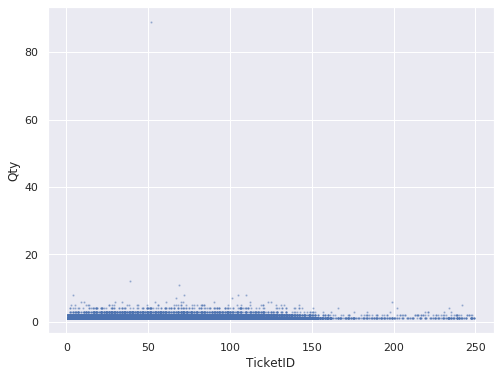

In [ ]:
def var_scatter(dfS1TimeFrame2, var):
    ax=None
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    dfS1TimeFrame2.plot.scatter(x=var , y="Qty", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(dfS1TimeFrame2, "TicketID");

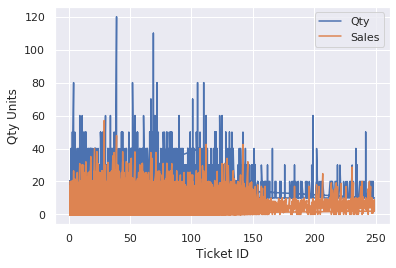

In [ ]:
plt.plot(dfS1TimeFrame2.TicketID,dfS1TimeFrame2.Qty * 10)
plt.plot(dfS1TimeFrame2.TicketID,dfS1TimeFrame2.Sales/10**2)
plt.legend(['Qty', 'Sales'])
plt.xlabel('Ticket ID')
plt.ylabel('Qty Units')
plt.show()

In [ ]:
#google drive authentication to save file in drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Item Name Corpus Document Creation for Time Frame 2

In [ ]:
def CreateCorpusFromDataFrame(inputData):
    itemNameDict = {}
    id = 1
    try:
        corpusfile = open('/content/gdrive/My Drive/CAPSTONE Project: Data Pirates/itemNameDocumentStr1TF2.txt', 'w')
        corpusfile.write('StoreID|PeriodID|TicketID|ItemName|Sales\n')

        for index, r in inputData.iterrows():
            storeID = r['StoreID']
            periodID = r['PeriodID']
            ticketID = r['TicketID']
            itemName = r['ItemName']
            qty = r['Qty']
            totalSales = int(r['Sales'])
            testName = ""
            keyVal = str(periodID)+str(ticketID)
            #print(keyVal)

            if keyVal in itemNameDict:
                value = itemNameDict[keyVal]
                c_itemname = value.split('|')[3]
                if qty > 1:
                    for x in range(qty):
                        if testName == "":
                            testName = itemName
                        else:
                            testName =  testName +' '+itemName
                    #print("ItemName:::::::" + testName)
                else:
                    testName = itemName

                n_itemname = c_itemname + ' ' + testName
                #print(":::::::" + n_itemname)
                c_salesValue = int(value.split('|')[4])
                n_salesValue = c_salesValue + totalSales
                corpusString = str(storeID) + "|" + str(periodID) + "|" + str(ticketID) + "|" + str(n_itemname) + "|" + str(n_salesValue)
                itemNameDict.update({keyVal: corpusString})
            else:
                if qty > 1:
                    for x in range(qty-1):
                        itemName = itemName + ' ' + itemName
                #print("ItemName:::::::" + itemName)
                corpusString = str(storeID) + "|" + str(periodID) + "|" + str(ticketID) + "|" + str(itemName) + "|" + str(totalSales)
                itemNameDict.update({keyVal: corpusString})

            id = id + 1

        for x in itemNameDict:
            corpusfile.write(itemNameDict[x] + '\n')

    finally:
        corpusfile.close()


CreateCorpusFromDataFrame(dfS1TimeFrame2)

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
linkName = 'https://drive.google.com/open?id=1fDmO1CYUMGQVFYpq8tY9GaaA05hh6Iva'
fluff, id = linkName.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('itemNameDocumentStr1TF2.txt')
itemNameDataStr1TF2 = pd.read_csv('itemNameDocumentStr1TF2.txt', sep="|", engine='python')
itemNameDataStr1TF2.info()

1fDmO1CYUMGQVFYpq8tY9GaaA05hh6Iva
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17726 entries, 0 to 17725
Data columns (total 5 columns):
StoreID     17726 non-null int64
PeriodID    17726 non-null int64
TicketID    17726 non-null int64
ItemName    17726 non-null object
Sales       17726 non-null int64
dtypes: int64(4), object(1)
memory usage: 692.5+ KB


In [ ]:
itemNameDataStr1TF2.head()

,StoreID,PeriodID,TicketID,ItemName,Sales
0,1,20190101,1,Chevy-Tahoe WND,699
1,1,20190101,2,Chevy-Lanos WND WND Towing-Package Bose-Speakers,1417
2,1,20190101,3,Toyota-Porte,500
3,1,20190101,4,Ford-Explorer-Sport-Trac Apple,708
4,1,20190101,5,Toyota-Porte,500


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

In [ ]:
#select column to convert to list here
itemNameCorpusStr1TF2 = itemNameDataStr1TF2["ItemName"].tolist()
#itemNameCorpus
itemNameCorpusStr1TF2 = [x.lower() for x in itemNameCorpusStr1TF2]
len(itemNameCorpusStr1TF2)

17726

In [ ]:
#set() takes the unique values and set in vocabulary
vocabulary = set()
for documentValue in itemNameCorpusStr1TF2:
    vocabulary.update(documentValue.split())

len(vocabulary)

257

In [ ]:
vocabulary = list(vocabulary)

In [ ]:
wordInd = {word: idx for idx, word in enumerate(vocabulary)}

In [ ]:
tfidf = TfidfVectorizer(vocabulary=vocabulary, token_pattern=r"(?u)\S\S+")
tfidf.fit(itemNameCorpusStr1TF2)
tfidf.transform(itemNameCorpusStr1TF2)

<17726x257 sparse matrix of type '<class 'numpy.float64'>'
	with 55812 stored elements in Compressed Sparse Row format>

In [ ]:
tfidfItemNameStr1TF2DF = pd.DataFrame()
map = {'400w-power-inverter': 0,
 '600w-power-inverter': 0,
 'alan': 0,
 'allview': 0,
 'amazon': 0,
 'amoi': 0,
 'apartment': 0,
 'apple': 0,
 'archos': 0,
 'asus': 0,
 'at&t': 0,
 'australian-shepherd': 0,
 'benq': 0,
 'benq-siemens': 0,
 'bike-hauler': 0,
 'blackberry': 0,
 'blackview': 0,
 'bmc': 0,
 'bobble-head': 0,
 'bose-speakers': 0,
 'boxer': 0,
 'bq': 0,
 'bronze': 0,
 'built-in-phone': 0,
 'bungalow': 0,
 'cabin': 0,
 'cannondale': 0,
 'car-sales-decal': 0,
 'carriage/coach': 0,
 'cd-changer': 0,
 'cd-player': 0,
 'celkon': 0,
 'chalet': 0,
 'chevy-210': 0,
 'chevy-a-20': 0,
 'chevy-astro': 0,
 'chevy-avalanche': 0,
 'chevy-beretta': 0,
 'chevy-blazer': 0,
 'chevy-c/k': 0,
 'chevy-camaro': 0,
 'chevy-cameo': 0,
 'chevy-caprice': 0,
 'chevy-cavalier': 0,
 'chevy-celta': 0,
 'chevy-chevelle': 0,
 'chevy-cobalt': 0,
 'chevy-colorado': 0,
 'chevy-constantia': 0,
 'chevy-corvair': 0,
 'chevy-delray': 0,
 'chevy-g506': 0,
 'chevy-gemini': 0,
 'chevy-greenbrier': 0,
 'chevy-hhr': 0,
 'chevy-impala': 0,
 'chevy-lakewood': 0,
 'chevy-lanos': 0,
 'chevy-lee': 0,
 'chevy-mercury': 0,
 'chevy-monte-carlo': 0,
 'chevy-nova': 0,
 'chevy-onix': 0,
 'chevy-optra-wagon': 0,
 'chevy-silverado': 0,
 'chevy-sonic': 0,
 'chevy-standard': 0,
 'chevy-tahoe': 0,
 'chevy-trailblazer': 0,
 'chevy-traverse': 0,
 'chevy-uplander': 0,
 'chevy-van': 0,
 'chevy-vega': 0,
 'chevy-viking': 0,
 'chevy-viva': 0,
 'chrysler-airstream': 0,
 'chrysler-aspen': 0,
 'chrysler-cordoba': 0,
 'chrysler-crossfire': 0,
 'chrysler-fifth-avenue': 0,
 'chrysler-prowler': 0,
 'chrysler-royal': 0,
 'chrysler-saratoga': 0,
 'chrysler-sebring': 0,
 'chrysler-sunbeem': 0,
 'chrysler-town-and-country': 0,
 'co-op': 0,
 'condominium': 0,
 'cooler': 0,
 'cottage': 0,
 'crimson': 0,
 'dachshund': 0,
 'dash-camera': 0,
 'desert-sand': 0,
 'dodge-330': 0,
 'dodge-400': 0,
 'dodge-aries': 0,
 'dodge-eight': 0,
 'dodge-intrepid': 0,
 'dodge-kingsway': 0,
 'dodge-lancer': 0,
 'dodge-meadowbrook': 0,
 'dodge-olara': 0,
 'dodge-omni': 0,
 'dodge-ram-2500': 0,
 'dodge-ram-3500': 0,
 'dodge-stratus': 0,
 'dodge-viper': 0,
 'emergency-roadside-kit': 0,
 'febreeze-spray': 0,
 'felt': 0,
 'fire-extinguisher': 0,
 'first-aid-kit': 0,
 'fish-for-trailer-hitch': 0,
 'fix-a-flat': 0,
 'ford-aspire': 0,
 'ford-bronco': 0,
 'ford-camete': 0,
 'ford-contour': 0,
 'ford-crestline': 0,
 'ford-crown-victoria': 0,
 'ford-custom-500': 0,
 'ford-custom-deluxe': 0,
 'ford-del-rey': 0,
 'ford-e150': 0,
 'ford-e250': 0,
 'ford-edge': 0,
 'ford-eifel': 0,
 'ford-endeavor': 0,
 'ford-escape': 0,
 'ford-escort': 0,
 'ford-expedition': 0,
 'ford-explorer': 0,
 'ford-explorer-sport-trac': 0,
 'ford-f150': 0,
 'ford-f250': 0,
 'ford-festiva': 0,
 'ford-five-hundred': 0,
 'ford-flex': 0,
 'ford-focus': 0,
 'ford-fusion': 0,
 'ford-gt': 0,
 'ford-gt40': 0,
 'ford-gtx1': 0,
 'ford-kuga': 0,
 'ford-lobo': 0,
 'ford-model-11a/1ga': 0,
 'ford-model-69a/gga': 0,
 'ford-model-73/77': 0,
 'ford-model-8-46': 0,
 'ford-model-ac': 0,
 'ford-model-b': 0,
 'ford-model-bb': 0,
 'ford-model-c': 0,
 'ford-probe': 0,
 'ford-quadricycle': 0,
 'ford-ranch-wagon': 0,
 'ford-svt-raptor': 0,
 'ford-taurus': 0,
 'ford-telstar': 0,
 'ford-tempo': 0,
 'ford-transcontinental': 0,
 'ford-xl': 0,
 'french-bulldog': 0,
 'fuji': 0,
 'german-pointer': 0,
 'german-shepherd': 0,
 'golden-retriever': 0,
 'google': 0,
 'gps-unit': 0,
 'halogen-lights': 0,
 'highspeed-charger': 0,
 'in-law-suite': 0,
 'inflatable-car-jack': 0,
 'jamis': 0,
 'jumper-cables': 0,
 'keychain': 0,
 'kia-k4': 0,
 'kia-optima': 0,
 'kia-picanto': 0,
 'kia-rio': 0,
 'kia-sedona': 0,
 'kia-stinger': 0,
 'kia-telluride': 0,
 'leather-cleaner': 0,
 'lg': 0,
 'light-covers': 0,
 'lincoln-2010': 0,
 'lincoln-continental': 0,
 'lincoln-mkx': 0,
 'luggage-hauler': 0,
 'luxury-package': 0,
 'mansion': 0,
 'map-holder': 0,
 'marin': 0,
 'merida': 0,
 'metallic-blue': 0,
 'microsoft': 0,
 'multi-family': 0,
 'navigation-system': 0,
 'nec': 0,
 'newfoundland': 0,
 'nylon-seat-covers': 0,
 'obd2-scanner': 0,
 'ochre': 0,
 'parking-sensors': 0,
 'periwinkle': 0,
 'pillows': 0,
 'pomeranian': 0,
 'poodle': 0,
 'preimum-car-wash': 0,
 'premium-seat-covers': 0,
 'radar-detector': 0,
 'ranch-style': 0,
 'rear-spoiler': 0,
 'rear-view-mirror-ball': 0,
 'regular-floor-mats': 0,
 'roll-bar': 0,
 'roll-cage': 0,
 'rolling-pin': 0,
 'safety-hammer': 0,
 'samsung': 0,
 'saturn-ion': 0,
 'saturn-sky': 0,
 'seatbelt-cutter': 0,
 'shetland-sheepdog': 0,
 'single-family-(detached)': 0,
 'smart-dirving-assistant': 0,
 'socket-set': 0,
 'solor-powered-vent': 0,
 'sony': 0,
 'spare-tire-cover': 0,
 'sport-package': 0,
 'suction-grip': 0,
 'tan': 0,
 'tinted-windows': 0,
 'tiny': 0,
 'towing-package': 0,
 'townhome': 0,
 'toyota-4runner': 0,
 'toyota-century': 0,
 'toyota-corolla': 0,
 'toyota-crown': 0,
 'toyota-fortuner': 0,
 'toyota-isis': 0,
 'toyota-land-cruiser': 0,
 'toyota-porte': 0,
 'toyota-premio': 0,
 'toyota-tacoma': 0,
 'toyota-tundra': 0,
 'toyota-voxy': 0,
 'trek': 0,
 'vehicle-cover': 0,
 'vent-clip-on-air-freshener': 0,
 'wheelchair-ramp': 0,
 'wnd': 0,
 'worksman-cycles': 0}

In [ ]:
scoreValue={}
for document in itemNameCorpusStr1TF2:
    score={}
    transform = tfidf.transform([document])
    for value in document.split():
        score[value] = transform[0, tfidf.vocabulary_[value]]
    scoreValue = sorted(score.items(), key=operator.itemgetter(1), reverse=True)
    new_row = pd.Series()
    for a in scoreValue:
      map[a[0]] =a[1]
    new_row = pd.Series(map)
    tfidfItemNameStr1TF2DF = tfidfItemNameStr1TF2DF.append(new_row, ignore_index=True)
    #print ("\t", scoreValue)
    #print()

In [ ]:
tfidfItemNameStr1TF2DF.head()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,benq,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,bq,bronze,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,cd-changer,cd-player,celkon,chalet,chevy-210,chevy-a-20,chevy-astro,chevy-avalanche,chevy-beretta,chevy-blazer,chevy-c/k,...,roll-bar,roll-cage,rolling-pin,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,socket-set,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-isis,toyota-land-cruiser,toyota-porte,toyota-premio,toyota-tacoma,toyota-tundra,toyota-voxy,trek,vehicle-cover,vent-clip-on-air-freshener,wheelchair-ramp,wnd,worksman-cycles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414704,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477461,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477461,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477461,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477461,0.0


In [ ]:
tfidfItemNameStr1TF2DF.shape

(17726, 257)

In [ ]:
tfidfItemNameStr1TF2DF.describe()

,400w-power-inverter,600w-power-inverter,alan,allview,amazon,amoi,apartment,apple,archos,asus,at&t,australian-shepherd,benq,benq-siemens,bike-hauler,blackberry,blackview,bmc,bobble-head,bose-speakers,boxer,bq,bronze,built-in-phone,bungalow,cabin,cannondale,car-sales-decal,carriage/coach,cd-changer,cd-player,celkon,chalet,chevy-210,chevy-a-20,chevy-astro,chevy-avalanche,chevy-beretta,chevy-blazer,chevy-c/k,...,roll-bar,roll-cage,rolling-pin,safety-hammer,samsung,saturn-ion,saturn-sky,seatbelt-cutter,shetland-sheepdog,single-family-(detached),smart-dirving-assistant,socket-set,solor-powered-vent,sony,spare-tire-cover,sport-package,suction-grip,tan,tinted-windows,tiny,towing-package,townhome,toyota-4runner,toyota-century,toyota-corolla,toyota-crown,toyota-fortuner,toyota-isis,toyota-land-cruiser,toyota-porte,toyota-premio,toyota-tacoma,toyota-tundra,toyota-voxy,trek,vehicle-cover,vent-clip-on-air-freshener,wheelchair-ramp,wnd,worksman-cycles
count,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,...,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000
mean,0.641380,0.636243,0.433969,0.539075,0.550910,0.637668,0.562674,0.356839,0.594429,0.810016,0.533320,0.536829,0.438668,0.589812,0.565577,0.535293,0.643757,0.509722,0.356254,0.466426,0.654528,0.507116,0.413474,0.606047,0.640064,0.666523,0.462769,0.500124,0.468706,0.400041,0.268534,0.520771,0.586337,0.755251,0.331041,0.329122,0.048925,0.645215,0.638858,0.719730,...,0.571826,0.621157,0.139088,0.614847,0.390633,0.595032,0.438629,0.634706,0.714861,0.504127,0.536084,0.108507,0.569051,0.619839,0.516138,0.505736,0.554491,0.690304,0.631497,0.576239,0.573485,0.536265,0.598629,0.605386,0.577601,0.593176,0.836741,0.830663,0.789707,0.818728,0.883388,0.627402,0.575936,0.583710,0.514556,0.535250,0.408999,0.560678,0.387897,0.472654
std,0.165502,0.142495,0.125421,0.167581,0.163700,0.325725,0.148047,0.187239,0.152110,0.289024,0.167883,0.255529,0.387395,0.148113,0.151145,0.157703,0.177591,0.145781,0.370078,0.144198,0.203342,0.278871,0.340329,0.173139,0.101977,0.202395,0.139690,0.176864,0.147751,0.242307,0.298541,0.298767,0.301809,0.223268,0.363667,0.468412,0.193420,0.221291,0.169125,0.172433,...,0.173193,0.306603,0.251810,0.145864,0.149400,0.182064,0.441471,0.221907,0.423243,0.174755,0.184965,0.303483,0.149532,0.143665,0.150414,0.131312,0.138369,0.132966,0.173544,0.168507,0.182652,0.174178,0.217232,0.195617,0.219205,0.195064,0.067503,0.256320,0.224499,0.216144,0.103159,0.210982,0.204470,0.162638,0.191991,0.155448,0.379652,0.205828,0.157168,0.137444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
tfidfItemNameStr1TF2DF = tfidfItemNameStr1TF2DF.loc[:,(tfidfItemNameStr1TF2DF != 0).any(axis=0)]

In [ ]:
tfidfItemNameStr1TF2DF.describe()

,alan,allview,amazon,amoi,apartment,apple,archos,asus,benq,blackberry,blackview,bmc,boxer,bq,bronze,bungalow,cabin,cannondale,celkon,chalet,condominium,cooler,cottage,crimson,dachshund,felt,fuji,google,jamis,keychain,lg,mansion,marin,merida,microsoft,nec,newfoundland,ochre,periwinkle,pillows,pomeranian,poodle,samsung,sony,tan,tiny,townhome,trek,wnd
count,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000,17726.000000
mean,0.604578,0.783663,0.798147,0.749814,0.735579,0.756871,0.886109,0.872418,0.491211,0.829670,0.821559,0.654538,0.839282,0.723627,0.577525,0.850938,0.806764,0.598138,0.704573,0.714918,0.788868,0.769483,0.655675,0.686167,0.246407,0.535766,0.681301,0.768067,0.723119,0.974783,0.805648,0.602949,0.597646,0.790208,0.746149,0.719383,0.901855,0.891741,0.683268,0.563283,0.561525,0.837879,0.790252,0.817656,0.836633,0.770325,0.735591,0.627513,0.801078
std,0.192176,0.163613,0.204838,0.382727,0.163009,0.281006,0.133699,0.301564,0.440408,0.163699,0.235492,0.156849,0.220574,0.380203,0.462441,0.112256,0.126921,0.167866,0.392639,0.348533,0.187033,0.317468,0.247637,0.378863,0.395898,0.320454,0.174665,0.236639,0.287566,0.156789,0.199866,0.379471,0.150859,0.185780,0.195307,0.187616,0.092485,0.217148,0.181052,0.311311,0.324818,0.141156,0.231852,0.151145,0.145085,0.179259,0.195701,0.249410,0.238332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094497
25%,0.471252,0.662468,0.697151,0.850251,0.626573,0.554290,0.886867,0.908651,0.000000,0.756457,0.738269,0.539873,0.819072,0.654919,0.000000,0.847415,0.731927,0.454581,0.503933,0.610813,0.724892,0.825724,0.548232,0.667008,0.000000,0.438061,0.530826,0.603277,0.738473,1.000000,0.671457,0.000000,0.499474,0.749347,0.596117,0.591987,0.806922,0.916207,0.551561,0.707884,0.614757,0.812805,0.686345,0.723441,0.784806,0.712462,0.573103,0.581677,0.640105
50%,0.614916,0.785858,0.860430,0.964566,0.768436,1.000000,0.947720,1.000000,0.661462,0.876318,0.789075,0.700657,0.913334,0.946177,0.938255,0.891978,0.779498,0.646171,0.932817,0.826705,0.843535,0.910234,0.647645,0.901110,0.000000,0.612862,0.719096,0.832323,0.738473,1.000000,0.875543,0.728826,0.603957,0.866872,0.781272,0.719009,0.915025,0.953720,0.712957,0.707884,0.614757,0.878130,0.817050,0.846570,0.894662,0.836559,0.840836,0.651316,0.920830
75%,0.766751,0.921806,1.000000,0.964566,0.881340,1.000000,0.947720,1.000000,0.946791,0.939051,1.000000,0.765616,0.943797,0.960502,0.938255,0.891978,0.963055,0.710921,0.970217,1.000000,0.934132,0.946321,0.837216,0.901110,0.754482,0.789246,0.849900,1.000000,0.969321,1.000000,1.000000,0.905112,0.706939,0.905655,0.918411,0.906556,0.976556,0.956236,0.818525,0.707884,0.897660,0.922450,1.000000,0.956627,0.932817,0.901157,0.905655,0.788213,1.000000
max,1.000000,1.000000,1.000000,0.964566,0.967905,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.955631,1.000000,1.000000,0.964566,0.954272,1.000000,1.000000,1.000000,1.000000,1.000000,0.975092,1.000000,0.953720,1.000000,0.966402,0.955156,1.000000,0.980942,1.000000,1.000000,0.905112,0.939064,1.000000,1.000000,1.000000,1.00000

In [ ]:
tfidfItemNameStr1TF2DF.shape

(17726, 49)

## **Time frame 2 Cluster Analysis of TF-IDF Data for Item Name**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
sctfidfStr2TF2DFIName = StandardScaler().fit_transform(tfidfItemNameStr1TF2DF)
sctfidfStr2TF2DFIName

array([[-3.87546126, -4.46515503, -3.46018938, ..., -2.7240893 ,
         0.17056981, -3.43899465],
       [-3.87546126, -4.46515503, -3.46018938, ..., -2.7240893 ,
         0.56987945, -3.43899465],
       [-3.87546126, -4.46515503, -3.46018938, ..., -2.7240893 ,
         0.56987945, -3.43899465],
       ...,
       [-1.86129992, -0.83624631,  0.5883321 , ...,  0.52507955,
        -1.34823162, -0.19290644],
       [-1.86129992, -0.83624631,  0.5883321 , ...,  0.52507955,
        -1.52194841, -0.19290644],
       [-1.86129992, -0.83624631,  0.5883321 , ...,  0.52507955,
        -1.52194841, -0.19290644]])

## Using PCA 71 components - Same as base period

In [ ]:
pcaTF2 = PCA(n_components=71)
principalComponentsTF2 = pcaTF2.fit_transform(sctfidfStr2TF2DFIName)
pcatfidfDFINameStr1TF2 = pd.DataFrame(data = principalComponentsTF2, columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28', 'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35', 'pca36', 'pca37', 'pca38', 'pca39', 'pca40','pca41', 'pca42', 'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49', 'pca50','pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56', 'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63', 'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70','pca71'])

  * TF 2 PCA 71 Silhoutte Result Analysis

In [ ]:
SilResultTF2DF = pd.DataFrame(columns = ['PCAComponents', 'Cls2SilScore', 'Cls2Centroids','Cls3SilScore', 'Cls3Centroids','Cls4SilScore', 'Cls4Centroids','Cls5SilScore', 'Cls5Centroids','Cls6SilScore', 'Cls6Centroids','Cls7SilScore', 'Cls7Centroids','Cls8SilScore', 'Cls8Centroids','Cls9SilScore', 'Cls9Centroids','Cls10SilScore', 'Cls10Centroids'])

In [ ]:
SilResultTF2DF

,PCAComponents,Cls2SilScore,Cls2Centroids,Cls3SilScore,Cls3Centroids,Cls4SilScore,Cls4Centroids,Cls5SilScore,Cls5Centroids,Cls6SilScore,Cls6Centroids,Cls7SilScore,Cls7Centroids,Cls8SilScore,Cls8Centroids,Cls9SilScore,Cls9Centroids,Cls10SilScore,Cls10Centroids


In [ ]:
#executing TF1 with cluster value 5
pca = PCA(n_components=71)
principalComponents = pca.fit_transform(sctfidfStr1TF1DFIName)
pcatfidfStr1TF1DFIName = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28', 'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35', 'pca36', 'pca37', 'pca38', 'pca39', 'pca40','pca41', 'pca42', 'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49', 'pca50','pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56', 'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63', 'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70','pca71'])
clusterer = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pcatfidfStr1TF1DFIName)

---------------------------------------------------------------------

The average silhouette scores :
For clusterVal = 5 The average silhouette_score is : 0.13703777730386604

The cluster level silhouette scores of  5  clusters: 
For clusterVal =  0 The size of cluster :  7602 , Minimum Silhouette Value =  -0.047491056417148826 , Maximum Silhouette Value =  0.16300266365881055
Number of silhouette scores less than 0:  367
For clusterVal =  1 The size of cluster :  3330 , Minimum Silhouette Value =  -0.08282871917533773 , Maximum Silhouette Value =  0.27410853371572086
Number of silhouette scores less than 0:  165
For clusterVal =  2 The size of cluster :  1217 , Minimum Silhouette Value =  -0.032936179718525034 , Maximum Silhouette Value =  0.39931150747404925
Number of silhouette scores less than 0:  20
For clusterVal =  3 The size of cluster :  404 , Minimum Silhouette Value =  0.05768141075097352 , Maximum Silhouette Value =  0.4118315846921334
For clusterVal =  4 The size of clust

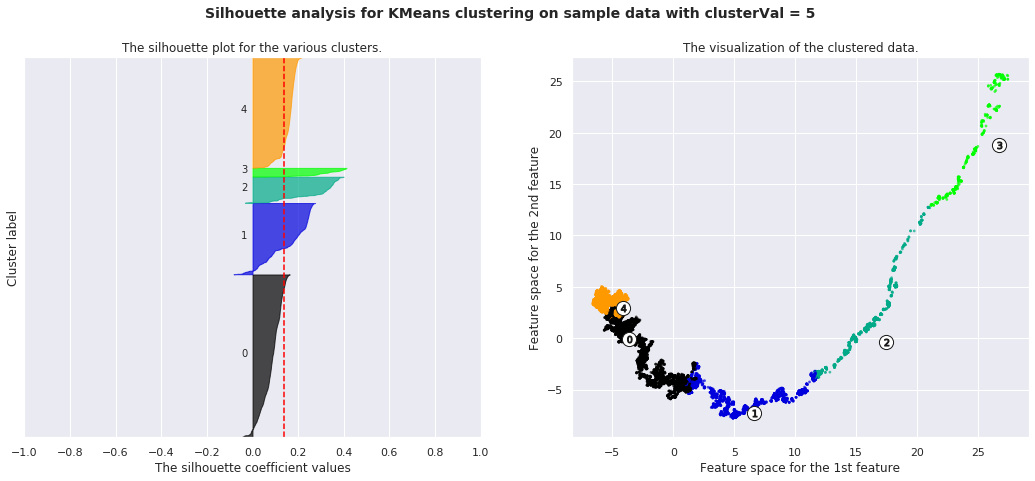

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

clusterRange = range(5, 6)

for clusterVal in clusterRange:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    # The (clusterVal+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcatfidfDFINameStr1TF2) + (clusterVal + 1) * 10])

    cluster_labels = clusterer.predict(pcatfidfDFINameStr1TF2)

    # silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pcatfidfDFINameStr1TF2, cluster_labels)
    print("---------------------------------------------------------------------")
    print()
    print("The average silhouette scores :")
    print("For clusterVal =", clusterVal,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcatfidfDFINameStr1TF2, cluster_labels)

    y_lower = 10
    negativeCount = 0
    print()
    print("The cluster level silhouette scores of ", clusterVal, " clusters: ")
    for i in range(clusterVal):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        print("For clusterVal = ", i,
              "The size of cluster : ", size_cluster_i,
              ", Minimum Silhouette Value = ", ith_cluster_silhouette_values[0],
              ", Maximum Silhouette Value = ", ith_cluster_silhouette_values[size_cluster_i - 1])
        if ith_cluster_silhouette_values[0] < 0:
            print("Number of silhouette scores less than 0: ",
                  len(ith_cluster_silhouette_values[ith_cluster_silhouette_values < 0]))
            negativeCount = negativeCount + len(ith_cluster_silhouette_values[ith_cluster_silhouette_values < 0])

        color = cm.nipy_spectral(float(i) / clusterVal)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    print()
    print("Positive silhouette score accuracy for ", clusterVal, " clusters = ",
          (sample_silhouette_values.shape[0] - negativeCount) / sample_silhouette_values.shape[0])
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusterVal)
    ax2.scatter(pcatfidfDFINameStr1TF2['pca1'], pcatfidfDFINameStr1TF2['pca2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with clusterVal = %d" % clusterVal),
                 fontsize=14, fontweight='bold')

    if clusterVal == 5:
      cl1 = [centers[:, 0][0], centers[:, 1][0]]
      cl2 = [centers[:, 0][1], centers[:, 1][1]]
      cl3 = [centers[:, 0][2], centers[:, 1][2]]
      cl4 = [centers[:, 0][3], centers[:, 1][3]]
      cl5 = [centers[:, 0][4], centers[:, 1][4]]
      coordinate = [cl1,cl2,cl3,cl4,cl5]
      print("in cluster 5")
      print(coordinate)

plt.show()

In [ ]:
itemNameNclsStr1Tf2DF= itemNameDataStr1TF2

In [ ]:
clustering_kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pcatfidfDFINameStr1TF2['clusters'] = clustering_kmeans.fit_predict(pcatfidfDFINameStr1TF2)

In [ ]:
itemNameNclsStr1Tf2DF['clusters'] = pcatfidfDFINameStr1TF2['clusters']

In [ ]:
# execute below code only to drop cluster column from dataframe
itemNameDataStr1TF2 = itemNameDataStr1TF2.drop(itemNameDataStr1TF2.columns[-1],axis=1)

In [ ]:
itemNameNclsS1TF2DFCls0 = itemNameNclsStr1Tf2DF[itemNameNclsStr1Tf2DF['clusters'] == 0]
itemNameNclsS1TF2DFCls1 = itemNameNclsStr1Tf2DF[itemNameNclsStr1Tf2DF['clusters'] == 1]
itemNameNclsS1TF2DFCls2 = itemNameNclsStr1Tf2DF[itemNameNclsStr1Tf2DF['clusters'] == 2]
itemNameNclsS1TF2DFCls3 = itemNameNclsStr1Tf2DF[itemNameNclsStr1Tf2DF['clusters'] == 3]
itemNameNclsS1TF2DFCls4 = itemNameNclsStr1Tf2DF[itemNameNclsStr1Tf2DF['clusters'] == 4]

In [ ]:
TotalTcktIdsNcls0 = len(itemNameNclsS1TF2DFCls0)
TotalTcktIdsNcls1 = len(itemNameNclsS1TF2DFCls1)
TotalTcktIdsNcls2 = len(itemNameNclsS1TF2DFCls2)
TotalTcktIdsNcls3 = len(itemNameNclsS1TF2DFCls3)
TotalTcktIdsNcls4 = len(itemNameNclsS1TF2DFCls4)
#TotalTcktIdsNcls5 = len(itemNameNclsS1TF1DFCls5)
#TotalTcktIdsNcls6 = len(itemNameNclsS1TF1DFCls6)
#TotalTcktIdsNcls7 = len(itemNameNclsS1TF1DFCls7)
#TotalTcktIdsNcls8 = len(itemNameNclsS1TF1DFCls8)
#TotalTcktIdsNcls9 = len(itemNameNclsS1TF1DFCls9)

TotalSalesNcls0 = itemNameNclsS1TF2DFCls0['Sales'].sum()
AvgSalesNcls0 = itemNameNclsS1TF2DFCls0['Sales'].mean()

TotalSalesNcls1 = itemNameNclsS1TF2DFCls1['Sales'].sum()
AvgSalesNcls1 = itemNameNclsS1TF2DFCls1['Sales'].mean()

TotalSalesNcls2 = itemNameNclsS1TF2DFCls2['Sales'].sum()
AvgSalesNcls2 = itemNameNclsS1TF2DFCls2['Sales'].mean()

TotalSalesNcls3 = itemNameNclsS1TF2DFCls3['Sales'].sum()
AvgSalesNcls3 = itemNameNclsS1TF2DFCls3['Sales'].mean()

TotalSalesNcls4 = itemNameNclsS1TF2DFCls4['Sales'].sum()
AvgSalesNcls4 = itemNameNclsS1TF2DFCls4['Sales'].mean()

#TotalSalesNcls5 = itemNameNclsS1TF1DFCls5['Sales'].sum()
#AvgSalesNcls5 = itemNameNclsS1TF1DFCls5['Sales'].mean()

#TotalSalesNcls6 = itemNameNclsS1TF1DFCls6['Sales'].sum()
#AvgSalesNcls6 = itemNameNclsS1TF1DFCls6['Sales'].mean()

#TotalSalesNcls7 = itemNameNclsS1TF1DFCls7['Sales'].sum()
#AvgSalesNcls7 = itemNameNclsS1TF1DFCls7['Sales'].mean()

#TotalSalesNcls8 = itemNameNclsS1TF1DFCls8['Sales'].sum()
#AvgSalesNcls8 = itemNameNclsS1TF1DFCls8['Sales'].mean()

#TotalSalesNcls9 = itemNameNclsS1TF1DFCls9['Sales'].sum()
#AvgSalesNcls9 = itemNameNclsS1TF1DFCls9['Sales'].mean()

print("PCA71 WITH 5 CLUSTER ANALYSIS")
print()
print(f" The total number of ticket ids in Cluster 1 of 10 clusters: {TotalTcktIdsNcls0}")
print(f" The total Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: ${TotalSalesNcls0}")
print(f" The avg Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: ${AvgSalesNcls0}")
print()
print(f" The total number of ticket ids in Cluster 2 of 10 clusters: {TotalTcktIdsNcls1}")
print(f" The total Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: ${TotalSalesNcls1}")
print(f" The avg Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: ${AvgSalesNcls1}")
print()
print(f" The total number of ticket ids in Cluster 3 of 10 clusters: {TotalTcktIdsNcls2}")
print(f" The total Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: ${TotalSalesNcls2}")
print(f" The avg Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: ${AvgSalesNcls2}")
print()
print(f" The total number of ticket ids in Cluster 4 of 10 clusters: {TotalTcktIdsNcls3}")
print(f" The total Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: ${TotalSalesNcls3}")
print(f" The avg Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: ${AvgSalesNcls3}")
print()
print(f" The total number of ticket ids in Cluster 5 of 10 clusters: {TotalTcktIdsNcls4}")
print(f" The total Sales Amount of Cluster 5 of 10 clusters for all Ticket IDs: ${TotalSalesNcls4}")
print(f" The avg Sales Amount of Cluster 5 of 10 clusters for all Ticket IDs: ${AvgSalesNcls4}")

PCA71 WITH 5 CLUSTER ANALYSIS

 The total number of ticket ids in Cluster 1 of 10 clusters: 8494
 The total Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: $13870457
 The avg Sales Amount of Cluster 1 of 10 clusters for all Ticket IDs: $1632.9711561101954

 The total number of ticket ids in Cluster 2 of 10 clusters: 2294
 The total Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: $3564335
 The avg Sales Amount of Cluster 2 of 10 clusters for all Ticket IDs: $1553.7641673931996

 The total number of ticket ids in Cluster 3 of 10 clusters: 448
 The total Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: $690548
 The avg Sales Amount of Cluster 3 of 10 clusters for all Ticket IDs: $1541.4017857142858

 The total number of ticket ids in Cluster 4 of 10 clusters: 1514
 The total Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: $2263835
 The avg Sales Amount of Cluster 4 of 10 clusters for all Ticket IDs: $1495.2675033025098

 The total number 

In [ ]:
clsAnlysData={}
clsAnlysData.update({'TF':'TF2', 'PCAComponents': 71, 'NoClusters':5, 'TtlTicketIdcls1':TotalTcktIdsNcls0, 'TtlTicketIdcls2':TotalTcktIdsNcls1,'TtlTicketIdcls3':TotalTcktIdsNcls2,'TtlTicketIdcls4':TotalTcktIdsNcls3,'TtlTicketIdcls5':TotalTcktIdsNcls4,'TtlSalesAmountCls1':TotalSalesNcls0,'TtlSalesAmountCls2':TotalSalesNcls1,'TtlSalesAmountCls3':TotalSalesNcls2,'TtlSalesAmountCls4':TotalSalesNcls3,'TtlSalesAmountCls5':TotalSalesNcls4,'AvgSalesAmountCls1':AvgSalesNcls0,'AvgSalesAmountCls2':AvgSalesNcls1,'AvgSalesAmountCls3':AvgSalesNcls2,'AvgSalesAmountCls4':AvgSalesNcls3,'AvgSalesAmountCls5':AvgSalesNcls4})
clsAnlysDF = clsAnlysDF.append(clsAnlysData, ignore_index=True)
clsAnlysDF

,TF,PCAComponents,NoClusters,TtlTicketIdcls1,TtlTicketIdcls2,TtlTicketIdcls3,TtlTicketIdcls4,TtlTicketIdcls5,TtlTicketIdcls6,TtlTicketIdcls7,TtlTicketIdcls8,TtlTicketIdcls9,TtlTicketIdcls10,TtlSalesAmountCls1,TtlSalesAmountCls2,TtlSalesAmountCls3,TtlSalesAmountCls4,TtlSalesAmountCls5,TtlSalesAmountCls6,TtlSalesAmountCls7,TtlSalesAmountCls8,TtlSalesAmountCls9,TtlSalesAmountCls10,AvgSalesAmountCls1,AvgSalesAmountCls2,AvgSalesAmountCls3,AvgSalesAmountCls4,AvgSalesAmountCls5,AvgSalesAmountCls6,AvgSalesAmountCls7,AvgSalesAmountCls8,AvgSalesAmountCls9,AvgSalesAmountCls10
0,TF1,71,5,5566,2051,276,1042,4583,NaN,NaN,NaN,NaN,NaN,8958355,3381259,403495,1646514,7137836,NaN,NaN,NaN,NaN,NaN,1609.478081,1648.590444,1461.938406,1580.147793,1557.459306,NaN,NaN,NaN,NaN,NaN
1,TF2,71,5,8494,2294,448,1514,4976,NaN,NaN,NaN,NaN,NaN,13870457,3564335,690548,2263835,7946810,NaN,NaN,NaN,NaN,NaN,1632.971156,1553.764167,1541.401786,1495.267503,1597.027733,NaN,NaN,NaN,NaN,NaN


In [ ]:
clsAnlysDF.to_excel('/content/gdrive/My Drive/CAPSTONE Project: Data Pirates/ClusterAnalysis TF1-2.xlsx')

In [ ]:
loadClsAnalysisDF = pd.read_excel('/content/gdrive/My Drive/CAPSTONE Project: Data Pirates/ClusterAnalysis TF1-2.xlsx')
loadClsAnalysisResult = pd.DataFrame(loadClsAnalysisDF, columns= loadClsAnalysisDF.columns)
loadClsAnalysisResult = loadClsAnalysisResult.loc[:, ~loadClsAnalysisResult.columns.str.contains('^Unnamed')]
loadClsAnalysisResult

,TF,PCAComponents,NoClusters,TtlTicketIdcls1,TtlTicketIdcls2,TtlTicketIdcls3,TtlTicketIdcls4,TtlTicketIdcls5,TtlTicketIdcls6,TtlTicketIdcls7,TtlTicketIdcls8,TtlTicketIdcls9,TtlTicketIdcls10,TtlSalesAmountCls1,TtlSalesAmountCls2,TtlSalesAmountCls3,TtlSalesAmountCls4,TtlSalesAmountCls5,TtlSalesAmountCls6,TtlSalesAmountCls7,TtlSalesAmountCls8,TtlSalesAmountCls9,TtlSalesAmountCls10,AvgSalesAmountCls1,AvgSalesAmountCls2,AvgSalesAmountCls3,AvgSalesAmountCls4,AvgSalesAmountCls5,AvgSalesAmountCls6,AvgSalesAmountCls7,AvgSalesAmountCls8,AvgSalesAmountCls9,AvgSalesAmountCls10
0,TF1,71,5,5566,2051,276,1042,4583,NaN,NaN,NaN,NaN,NaN,8958355,3381259,403495,1646514,7137836,NaN,NaN,NaN,NaN,NaN,1609.478081,1648.590444,1461.938406,1580.147793,1557.459306,NaN,NaN,NaN,NaN,NaN
1,TF2,71,5,8494,2294,448,1514,4976,NaN,NaN,NaN,NaN,NaN,13870457,3564335,690548,2263835,7946810,NaN,NaN,NaN,NaN,NaN,1632.971156,1553.764167,1541.401786,1495.267503,1597.027733,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfS1Aug = df1[df1.PeriodID <= 20180831]

In [ ]:
dfS1Sep = df1[(df1.PeriodID > 20180831) & (df1.PeriodID <= 20180931)]

In [ ]:
dfS1Sep.head()

,StoreID,StoreGroup,PeriodID,TicketID,ItemName,ItemCategory,Qty,Sales,Modifier
7811,1,A,20180901,1,Ford-Explorer-Sport-Trac,Automobile,1,519,0
7812,1,A,20180901,1,Kia-Rio,Automobile,1,759,0
7813,1,A,20180901,1,Apple,Phones,2,378,0
7814,1,A,20180901,2,Chevy-Ajax,Automobile,1,499,0
7815,1,A,20180901,2,Ford-Bronco,Automobile,1,859,0


In [ ]:
dfS1Oct = df1[(df1.PeriodID > 20180931) & (df1.PeriodID <= 20181031)]

In [ ]:
dfS1Nov = df1[(df1.PeriodID > 20181031) & (df1.PeriodID <= 20181131)]

In [ ]:
dfS1Dec = df1[(df1.PeriodID > 20181131) & (df1.PeriodID <= 20181231)]

In [ ]:
dfS1Jan = df1[(df1.PeriodID > 20181231) & (df1.PeriodID <= 20190131)]

In [ ]:
dfS1Feb = df1[(df1.PeriodID > 20190131) & (df1.PeriodID <= 20190231)]

In [ ]:
dfS1Mar = df1[(df1.PeriodID > 20190231) & (df1.PeriodID <= 20190331)]

In [ ]:
dfS1Apr = df1[(df1.PeriodID > 20190331) & (df1.PeriodID <= 20190431)]

In [ ]:
dfS1May = df1[(df1.PeriodID > 20190431) & (df1.PeriodID <= 20190531)]

In [ ]:
dfS1Jun = df1[(df1.PeriodID > 20190531) & (df1.PeriodID <= 20190631)]

In [ ]:
dfS1Jul = df1[df1.PeriodID >= 20190731]